In [1]:
from collections import Counter, defaultdict
import glob
import itertools
import json
import matplotlib.pyplot as plt
plt.style.use('../peptidome.mplstyle')

import numpy as np
import pandas as pd
from scipy.stats import sem


import sys
sys.path.append('..')

from lib import *
from lib.maxent import *


In [6]:
def compute_pc(arr):
    N = arr.shape[0]
    _, counts = np.unique(arr, return_counts=True, axis=0)
    return np.sum(counts * (counts - 1)) / (N * (N - 1))

In [2]:
fig_data_path = '../../figures/New Paper Figures/Figure Data'

## Load MHC Summary Results

In [10]:
models = ['independent', 'ncov', 'nskew', 'nskewfcov']
labels = ['Uniform', '1st moment', '2nd moment', '3rd moment', '2-point']
k='9'
n='1e7'
proteome='Human'
thin='60'

In [3]:
cols = ["A1","A2","B1","B2","C1","C2"]
haplotypes = pd.read_csv("data/top_500_allowed_haplotypes.txt",names=cols)

In [4]:
haplotypes

,A1,A2,B1,B2,C1,C2
0,HLA-A0101,HLA-A0201,HLA-B0702,HLA-B0801,HLA-C0701,HLA-C0702
1,HLA-A0201,HLA-A0301,HLA-B0702,HLA-B0801,HLA-C0701,HLA-C0702
2,HLA-A0201,HLA-A0201,HLA-B0702,HLA-B0801,HLA-C0701,HLA-C0702
3,HLA-A0101,HLA-A0201,HLA-B0702,HLA-B4402,HLA-C0701,HLA-C0702
4,HLA-A0101,HLA-A0201,HLA-B0702,HLA-B0801,HLA-C0401,HLA-C0701
...,...,...,...,...,...,...
495,HLA-A0101,HLA-A0201,HLA-B0702,HLA-B4402,HLA-C0701,HLA-C0802
496,HLA-A0201,HLA-A0201,HLA-B0702,HLA-B4001,HLA-C0501,HLA-C0702
497,HLA-A0201,HLA-A0301,HLA-B0801,HLA-B4001,HLA-C0602,HLA-C0701
498,HLA-A0101,HLA-A0201,HLA-B1501,HLA-B4402,HLA-C0501,HLA-C0702


In [13]:
model_s_dict = defaultdict(list)
model_pc_dict = defaultdict(list)
model_s_mhc_dict = defaultdict(list)
model_pc_mhc_dict = defaultdict(list)
model_pct_binder_dict = defaultdict(list)

for model in models:
    
    path_base = f"data/mhc_sampling_results/{proteome}_{model}_{n}_{thin}_"
    for idx,haplotype in haplotypes.iterrows():
        hap_str = "|".join(list(haplotype))
        with open(f"{path_base}{hap_str}.json","r") as f:
            result = json.load(f)
        
        model_s_dict[model].append(result['S'])
        model_s_mhc_dict[model].append(result['S_mhc_with_logb'])
        model_pc_dict[model].append(result['pc'])
        model_pc_mhc_dict[model].append(result['pc_mhc'])
        model_pct_binder_dict[model].append(result['b'])


0
HLA-A0101|HLA-A0201|HLA-B0702|HLA-B0801|HLA-C0701|HLA-C0702
0
HLA-A0101|HLA-A0201|HLA-B0702|HLA-B0801|HLA-C0701|HLA-C0702
0
HLA-A0101|HLA-A0201|HLA-B0702|HLA-B0801|HLA-C0701|HLA-C0702
0
HLA-A0101|HLA-A0201|HLA-B0702|HLA-B0801|HLA-C0701|HLA-C0702


In [17]:
# uniform
path_base = f"data/mhc_sampling_results/uniform_"
for idx,haplotype in haplotypes.iterrows():
    hap_str = "|".join(list(haplotype))
    with open(f"{path_base}{hap_str}.json","r") as f:
        result = json.load(f)

    model_s_dict['uniform'].append(result['S'])
    model_s_mhc_dict['uniform'].append(result['S_mhc_with_logb'])
    model_pc_dict['uniform'].append(result['pc'])
    model_pc_mhc_dict['uniform'].append(result['pc_mhc'])
    model_pct_binder_dict['uniform'].append(result['b'])

/scratch/lsftmp/10311929.tmpdir/ipykernel_34892/923888384.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(loc='best')


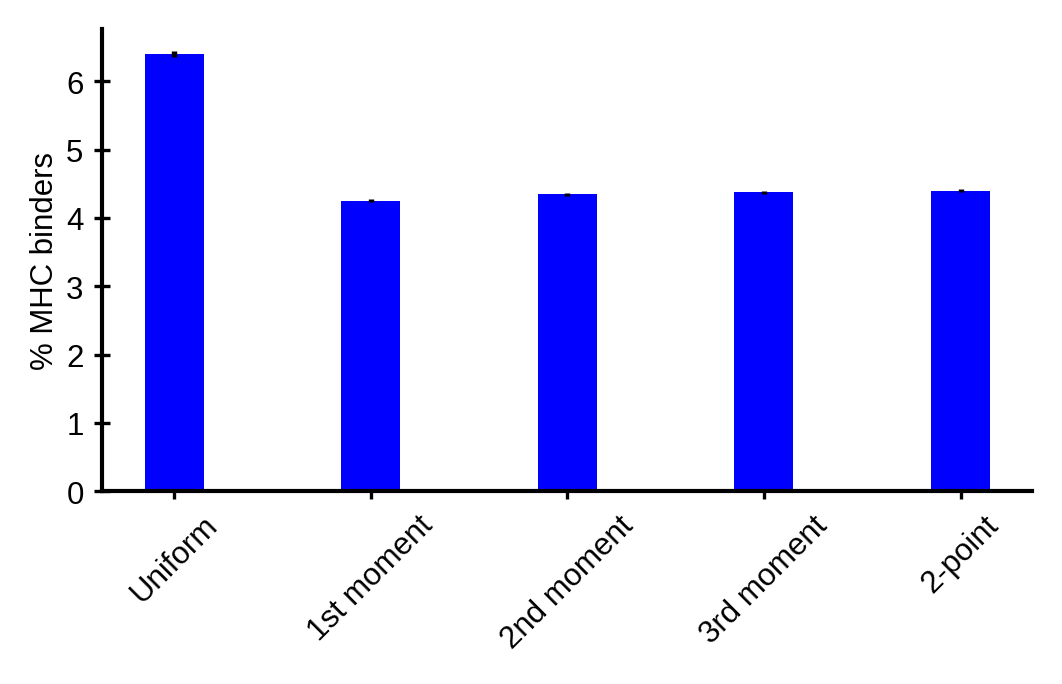

In [8]:
# percent binder plot

fig, ax1 = plt.subplots(figsize=(4, 2))

models = ['uniform', 'independent', 'ncov', 'nskew', 'nskewfcov']
mean_values = [100*np.mean(np.array(model_pct_binder_dict[model])) for model in models]
ste_values = [100*sem(np.array(model_pct_binder_dict[model])) for model in models]


ind = np.arange(len(models))
width = 0.3       
ax1.bar(ind, mean_values,width,yerr=ste_values,color='blue')
ax1.set_ylabel('% MHC binders')
ax1.set_xticks(ind, labels,rotation=45)
ax1.legend(loc='best')
plt.savefig('plots/percent_mhc_haplotypes.png')

In [12]:
pct_binders_data = {}
for model in models:
    pct_binders_data[model] = {
        'mean': 100*np.mean(np.array(model_pct_binder_dict[model])),
        'ste': 100*sem(np.array(model_pct_binder_dict[model]))
    }
    
with open(f'{fig_data_path}/pct_binders_top_500.json', 'w') as fp:
    json.dump(pct_binders_data, fp)

In [13]:
def get_diversity_mean_and_sem(values):
    mu = np.mean(np.array(values))
    sigma = sem(np.array(values))
    mu = np.exp(mu)/20**9
    sigma = np.exp(sigma)/20**9
    return (mu,sigma)


In [54]:
ste_mhc_values

[np.float64(1.9671068004759195e-12),
 np.float64(1.965936216670866e-12),
 np.float64(1.9671081627115186e-12),
 np.float64(1.9677089130025232e-12),
 np.float64(1.9677664787390218e-12)]

array([0, 1, 2, 3, 4])

<>:44: SyntaxWarning: invalid escape sequence '\e'
<>:44: SyntaxWarning: invalid escape sequence '\e'
/scratch/lsftmp/10311929.tmpdir/ipykernel_34892/509805108.py:44: SyntaxWarning: invalid escape sequence '\e'
  ax1.set_ylabel('$\exp(S)/20^k$')


-0.60
-0.65
-0.66
-0.68
-0.65
-0.66
-0.67
-0.69


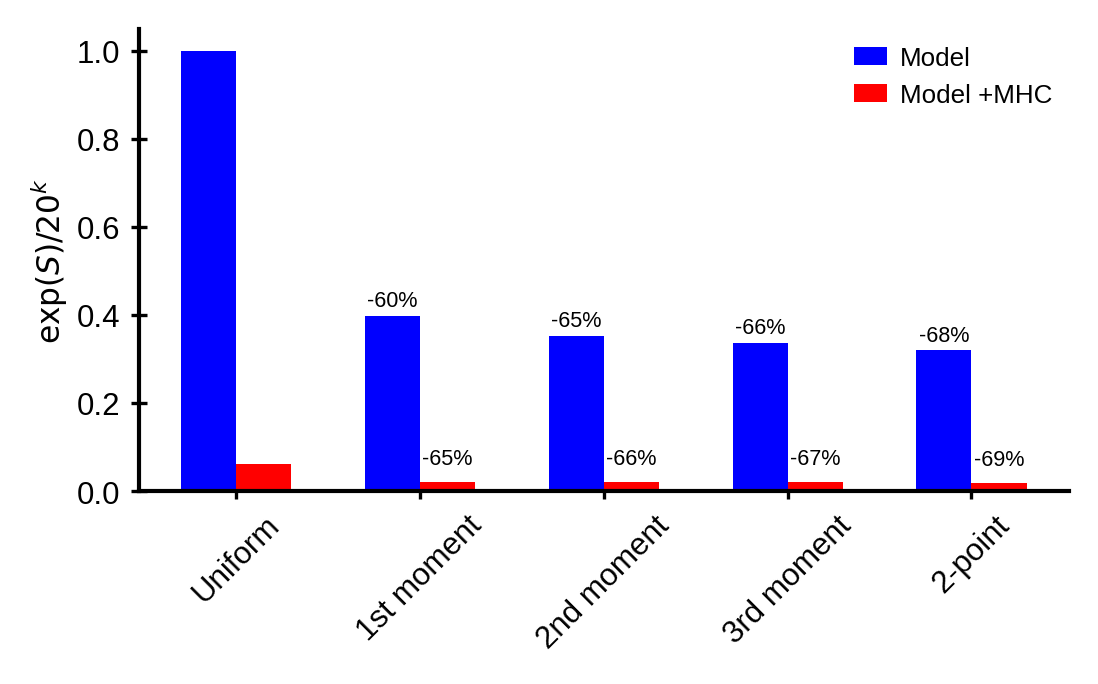

In [14]:
fig, ax1 = plt.subplots(figsize=(4, 2))

diversities = [get_diversity_mean_and_sem(model_s_dict[model]) for model in models]
mean_values = [d[0] for d in diversities]
ste_values = [d[1] for d in diversities]

diversities_mhc = [get_diversity_mean_and_sem(model_s_mhc_dict[model]) for model in models]
mean_mhc_values = [d[0] for d in diversities_mhc]
ste_mhc_values = [d[1] for d in diversities_mhc]

labels = ['Uniform', '1st moment', '2nd moment', '3rd moment', '2-point']
width = .3
x = np.arange(len(labels))
rects1 = ax1.bar(x, mean_values,width,   color='blue',label='Model')
rects2 = ax1.bar(x+width, mean_mhc_values, width, yerr=ste_mhc_values,color='red', label='Model +MHC')
# rects3 = ax1.bar(x[-1:], uniform_mhc/uniform_entropy, width, color='orange')
# rects2 = ax1.bar(x[-1:], uniform_entropy/uniform_entropy, width, color='black')

ax1.set_xticks(x+width/2)
ax1.set_xticklabels(labels, rotation=45)
# ax1.axhline(data[1]/data[0], ls='--')

reduction = ((mean_values[1:]-mean_values[0])/mean_values[0])
for rect, toplabel in zip(rects1[1:], reduction):
    print('{0:.2f}'.format(toplabel))
    ax1.annotate('{0:.0f}%'.format(100*toplabel),
                xy=(rect.get_x()+width/2, rect.get_height()),
                xytext=(0, 1),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize='xx-small')

    
    
    
reduction = ((mean_mhc_values[1:]-mean_mhc_values[0])/mean_mhc_values[0])
for rect, toplabel in zip(rects2[1:], reduction):
    print('{0:.2f}'.format(toplabel))
    ax1.annotate('{0:.0f}%'.format(100*toplabel),
                xy=(rect.get_x()+width/2, rect.get_height()+rect.get_height()*.9),
                xytext=(0, 1),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize='xx-small')    

ax1.set_ylabel('$\exp(S)/20^k$')
plt.legend()
plt.savefig('plots/shannon_all_models_haplotypes.png')

In [17]:
diversity_data = {}
for model in models:
    mean, ste = get_diversity_mean_and_sem(model_s_dict[model])
    mean_mhc, ste_mhc = get_diversity_mean_and_sem(model_s_mhc_dict[model])
    diversity_data[model] = {
        'mean': mean,
        'ste': ste,
        'mean_mhc': mean_mhc,
        'ste_mhc': ste_mhc
        
    }

with open(f'{fig_data_path}/diversity_top_500.json', 'w') as fp:
    json.dump(diversity_data, fp)

    

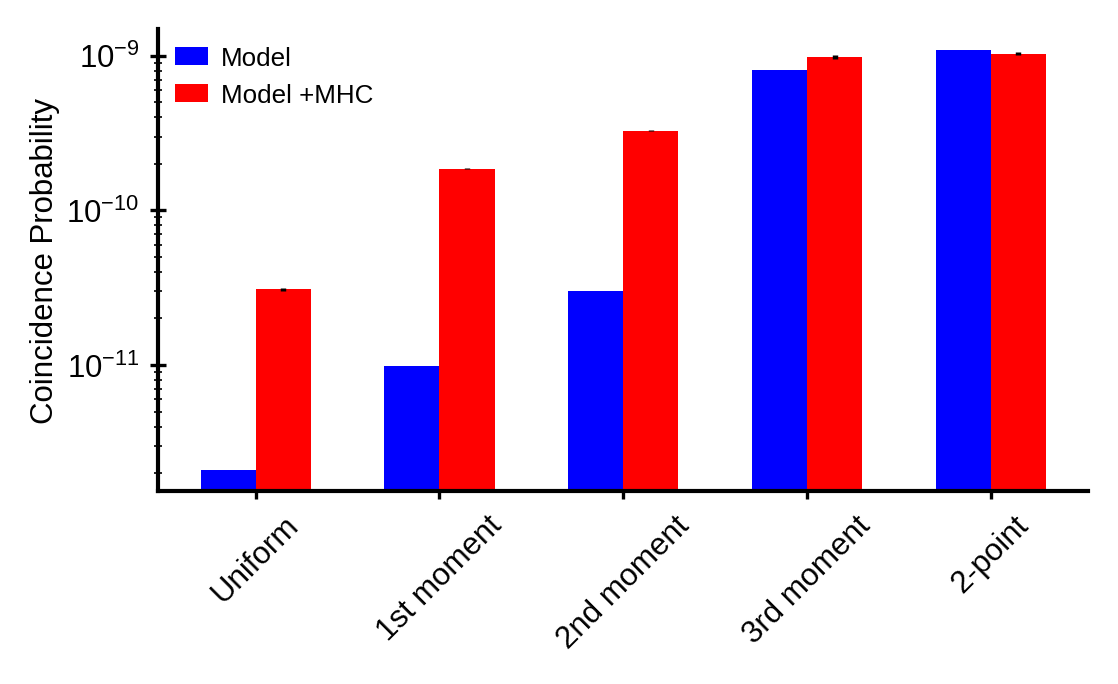

In [18]:
fig, ax1 = plt.subplots(figsize=(4, 2))

mean_values = [np.mean(model_pc_dict[model]) for model in models]

mean_mhc_values = [np.mean(model_pc_mhc_dict[model]) for model in models]
ste_mhc_values = [sem(np.array(model_pc_mhc_dict[model])) for model in models]

labels = ['Uniform', '1st moment', '2nd moment', '3rd moment', '2-point']
width = .3
x = np.arange(len(labels))
rects1 = ax1.bar(x, mean_values,width,   color='blue',label='Model')
rects2 = ax1.bar(x+width, mean_mhc_values, width, yerr=ste_mhc_values,color='red', label='Model +MHC')
# rects3 = ax1.bar(x[-1:], uniform_mhc/uniform_entropy, width, color='orange')
# rects2 = ax1.bar(x[-1:], uniform_entropy/uniform_entropy, width, color='black')

ax1.set_xticks(x+width/2)
ax1.set_xticklabels(labels, rotation=45)
# ax1.axhline(data[1]/data[0], ls='--')
ax1.set_yscale('log')

ax1.set_ylabel('Coincidence Probability')
plt.legend()
plt.savefig('plots/coincidence_haplotypes.png')

In [19]:
coincidence_data = {}
for model in models:
    mean = np.mean(model_pc_dict[model])
    mean_mhc = np.mean(model_pc_mhc_dict[model])
    ste_mhc = sem(model_pc_mhc_dict[model])
    coincidence_data[model] = {
        'mean': mean,
        'mean_mhc': mean_mhc,
        'ste_mhc': ste_mhc
        
    }

with open(f'{fig_data_path}/coincidence_top_500.json', 'w') as fp:
    json.dump(coincidence_data, fp)

    

## Top Haplotype

In [5]:
top_hap = haplotypes.loc[0]
list(top_hap)

['HLA-A0101', 'HLA-A0201', 'HLA-B0702', 'HLA-B0801', 'HLA-C0701', 'HLA-C0702']

In [7]:
def get_mhc_df(model, allele):
    try:
        return pd.read_csv(f'data/netMHC_output/net_mhc_output_{model}_{n}_{t}-{allele}.csv')

    except Exception as e:
        print(f'Missing CSV: {model},{allele}')
        return None
        
def get_combined_binders(model, alleles):

    kmers = set()
    for allele in alleles:
        print(allele)
        mhc_df = get_mhc_df(model, allele)
        if mhc_df is not None:
            kmers = kmers.union(set(mhc_df['Peptide']))
        else:
            print("DF is None")
    return kmers

In [91]:
proteome = 'Human'
models = ['independent', 'ncov', 'nskew', 'nskewfcov']



top_haplotype_data = {
    model: dict() for model in models
}

for model in models:
    print(f'model: {model}')
    energy = make_energy(np.load(f'data/{proteome}_{model}_k{k}_params.npz'))
    F = float(pd.read_csv(f"data/mcmc_thermo/{proteome}_{model}_{n}_{t}_entropy.csv",header=None, index_col=0).loc['F'].values[0])
    
    loglikelihood  = lambda seq: -energy(seq) + F
    
    matrix = load_matrix(f"data/mcmc_thermo/{proteome}_{model}_{n}_{t}_matrix.csv.gz")

    

    binders = get_combined_binders(model, list(top_hap))
    kmers = matrix_to_kmers(matrix)
    kmers_mhc = [km for km in kmers if km in binders]
    matrix_mhc = kmers_to_matrix(kmers_mhc)
    
    top_haplotype_data[model]['b'] = matrix_mhc.shape[0]/matrix.shape[0]
    top_haplotype_data[model]['pc'] = compute_pc(matrix)
    top_haplotype_data[model]['pc_mhc'] = compute_pc(matrix_mhc)

    energies = [energy(x) for x in matrix]
    top_haplotype_data[model]['energies'] = energies
    top_haplotype_data[model]['S'] = np.mean(np.array(energies)) - F 
   

    energies_mhc = [energy(x) for x in matrix_mhc]
    top_haplotype_data[model]['energies_mhc'] = energies_mhc
    top_haplotype_data[model]['S_mhc'] = np.mean(np.array(energies)) - F + np.log(top_haplotype_data[model]['b'])

model: independent
HLA-A0101
HLA-A0201
HLA-B0702
HLA-B0801
HLA-C0701
HLA-C0702
model: ncov
HLA-A0101
HLA-A0201
HLA-B0702
HLA-B0801
HLA-C0701
HLA-C0702
model: nskew
HLA-A0101
HLA-A0201
HLA-B0702
HLA-B0801
HLA-C0701
HLA-C0702
model: nskewfcov
HLA-A0101
HLA-A0201
HLA-B0702
HLA-B0801
HLA-C0701
HLA-C0702


In [93]:
top_haplotype_data['uniform'] = {
    'S': model_s_dict['uniform'][0],
    'S_mhc': model_s_mhc_dict['uniform'][0],
    'pc': model_pc_dict['uniform'][0],
    'pc_mhc': model_pc_mhc_dict['uniform'][0],
    'b': model_pct_binder_dict['uniform'][0]
}

/scratch/lsftmp/9501900.tmpdir/ipykernel_47952/3490662632.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(loc='best')


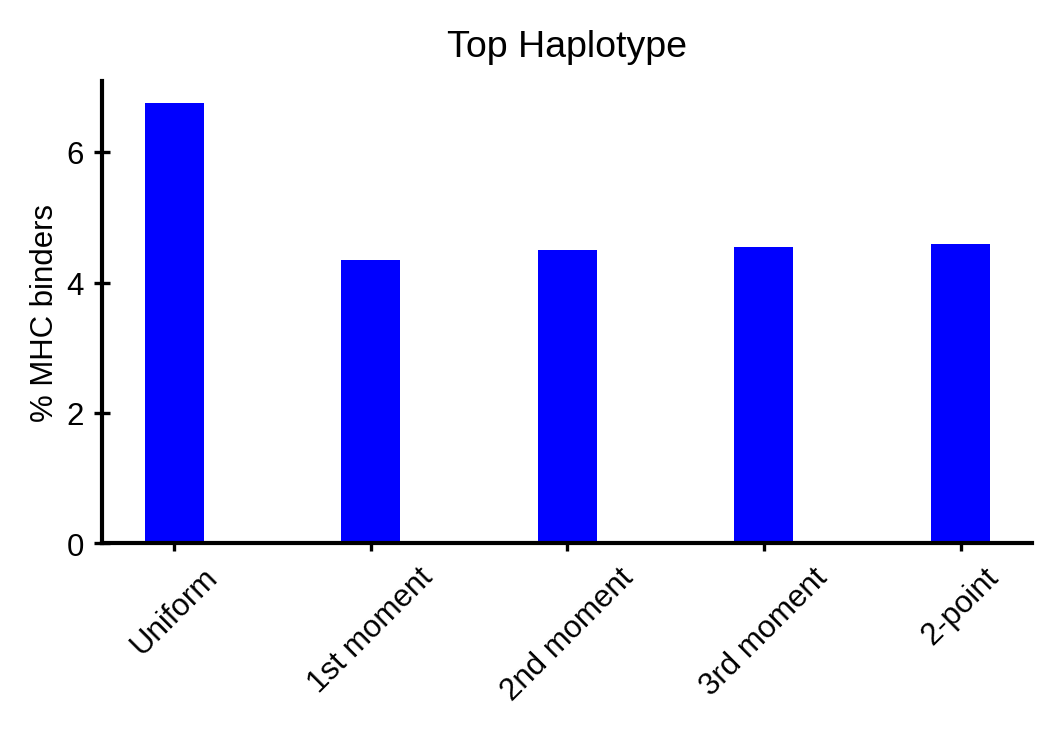

In [87]:
# percent binder plot

fig, ax1 = plt.subplots(figsize=(4, 2))

models = ['uniform', 'independent', 'ncov', 'nskew', 'nskewfcov']
values = [100*top_haplotype_data[model]['b'] for model in models]


ind = np.arange(len(models))
width = 0.3       
ax1.bar(ind, values,width,color='blue')
ax1.set_ylabel('% MHC binders')
ax1.set_xticks(ind, labels,rotation=45)
ax1.legend(loc='best')
plt.title('Top Haplotype')
plt.savefig('plots/percent_mhc_top_haplotype.png')

<>:41: SyntaxWarning: invalid escape sequence '\e'
<>:41: SyntaxWarning: invalid escape sequence '\e'
/scratch/lsftmp/9501900.tmpdir/ipykernel_47952/1067224469.py:41: SyntaxWarning: invalid escape sequence '\e'
  ax1.set_ylabel('$\exp(S)/20^k$')


-0.60
-0.65
-0.66
-0.68
-0.66
-0.67
-0.68
-0.70


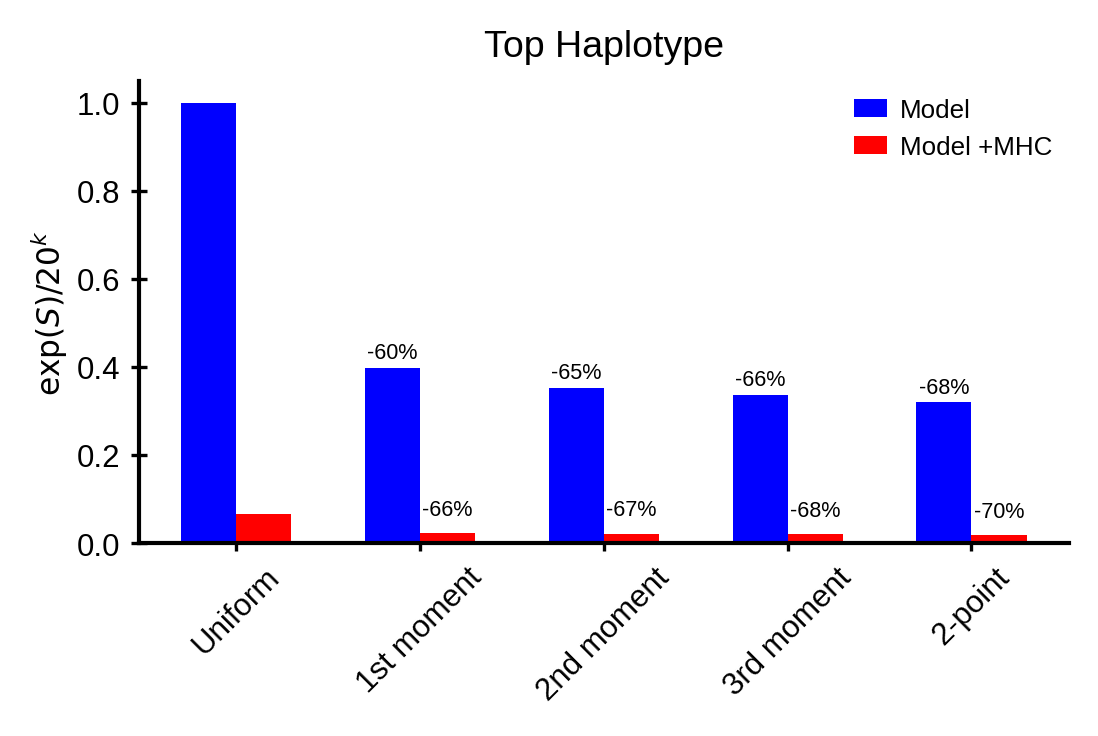

In [90]:
fig, ax1 = plt.subplots(figsize=(4, 2))

models = ['uniform', 'independent', 'ncov', 'nskew', 'nskewfcov']
values = [np.exp(top_haplotype_data[model]['S'])/20**9 for model in models]

values_mhc = [np.exp(top_haplotype_data[model]['S_mhc'])/20**9  for model in models]

labels = ['Uniform', '1st moment', '2nd moment', '3rd moment', '2-point']
width = .3
x = np.arange(len(labels))
rects1 = ax1.bar(x, values,width,   color='blue',label='Model')
rects2 = ax1.bar(x+width, values_mhc, width,color='red', label='Model +MHC')
# rects3 = ax1.bar(x[-1:], uniform_mhc/uniform_entropy, width, color='orange')
# rects2 = ax1.bar(x[-1:], uniform_entropy/uniform_entropy, width, color='black')

ax1.set_xticks(x+width/2)
ax1.set_xticklabels(labels, rotation=45)
# ax1.axhline(data[1]/data[0], ls='--')

reduction = ((values[1:]-values[0])/values[0])
for rect, toplabel in zip(rects1[1:], reduction):
    print('{0:.2f}'.format(toplabel))
    ax1.annotate('{0:.0f}%'.format(100*toplabel),
                xy=(rect.get_x()+width/2, rect.get_height()),
                xytext=(0, 1),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize='xx-small')

    
    
    
reduction = ((values_mhc[1:]-values_mhc[0])/values_mhc[0])
for rect, toplabel in zip(rects2[1:], reduction):
    print('{0:.2f}'.format(toplabel))
    ax1.annotate('{0:.0f}%'.format(100*toplabel),
                xy=(rect.get_x()+width/2, rect.get_height()+rect.get_height()*.9),
                xytext=(0, 1),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize='xx-small')    

ax1.set_ylabel('$\exp(S)/20^k$')
ax1.set_title('Top Haplotype')
plt.legend()
plt.savefig('plots/shannon_all_models_top_haplotype.png')

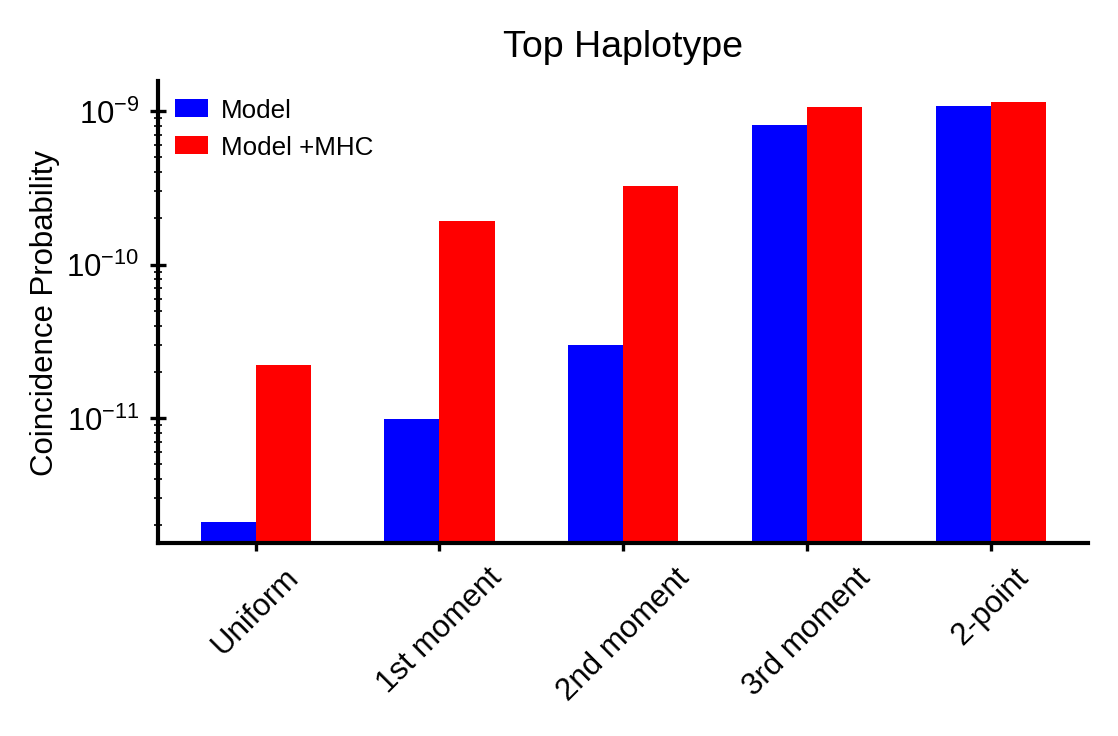

In [94]:
fig, ax1 = plt.subplots(figsize=(4, 2))
models = ['uniform', 'independent', 'ncov', 'nskew', 'nskewfcov']


values = [top_haplotype_data[model]['pc'] for model in models]

values_mhc = [top_haplotype_data[model]['pc_mhc'] for model in models]


labels = ['Uniform', '1st moment', '2nd moment', '3rd moment', '2-point']
width = .3
x = np.arange(len(labels))
rects1 = ax1.bar(x, values,width,   color='blue',label='Model')
rects2 = ax1.bar(x+width, values_mhc, width, color='red', label='Model +MHC')
# rects3 = ax1.bar(x[-1:], uniform_mhc/uniform_entropy, width, color='orange')
# rects2 = ax1.bar(x[-1:], uniform_entropy/uniform_entropy, width, color='black')

ax1.set_xticks(x+width/2)
ax1.set_xticklabels(labels, rotation=45)
# ax1.axhline(data[1]/data[0], ls='--')
ax1.set_yscale('log')

ax1.set_ylabel('Coincidence Probability')
ax1.set_title('Top Haplotype')
plt.legend()
plt.savefig('plots/coincidence_top_haplotype.png')

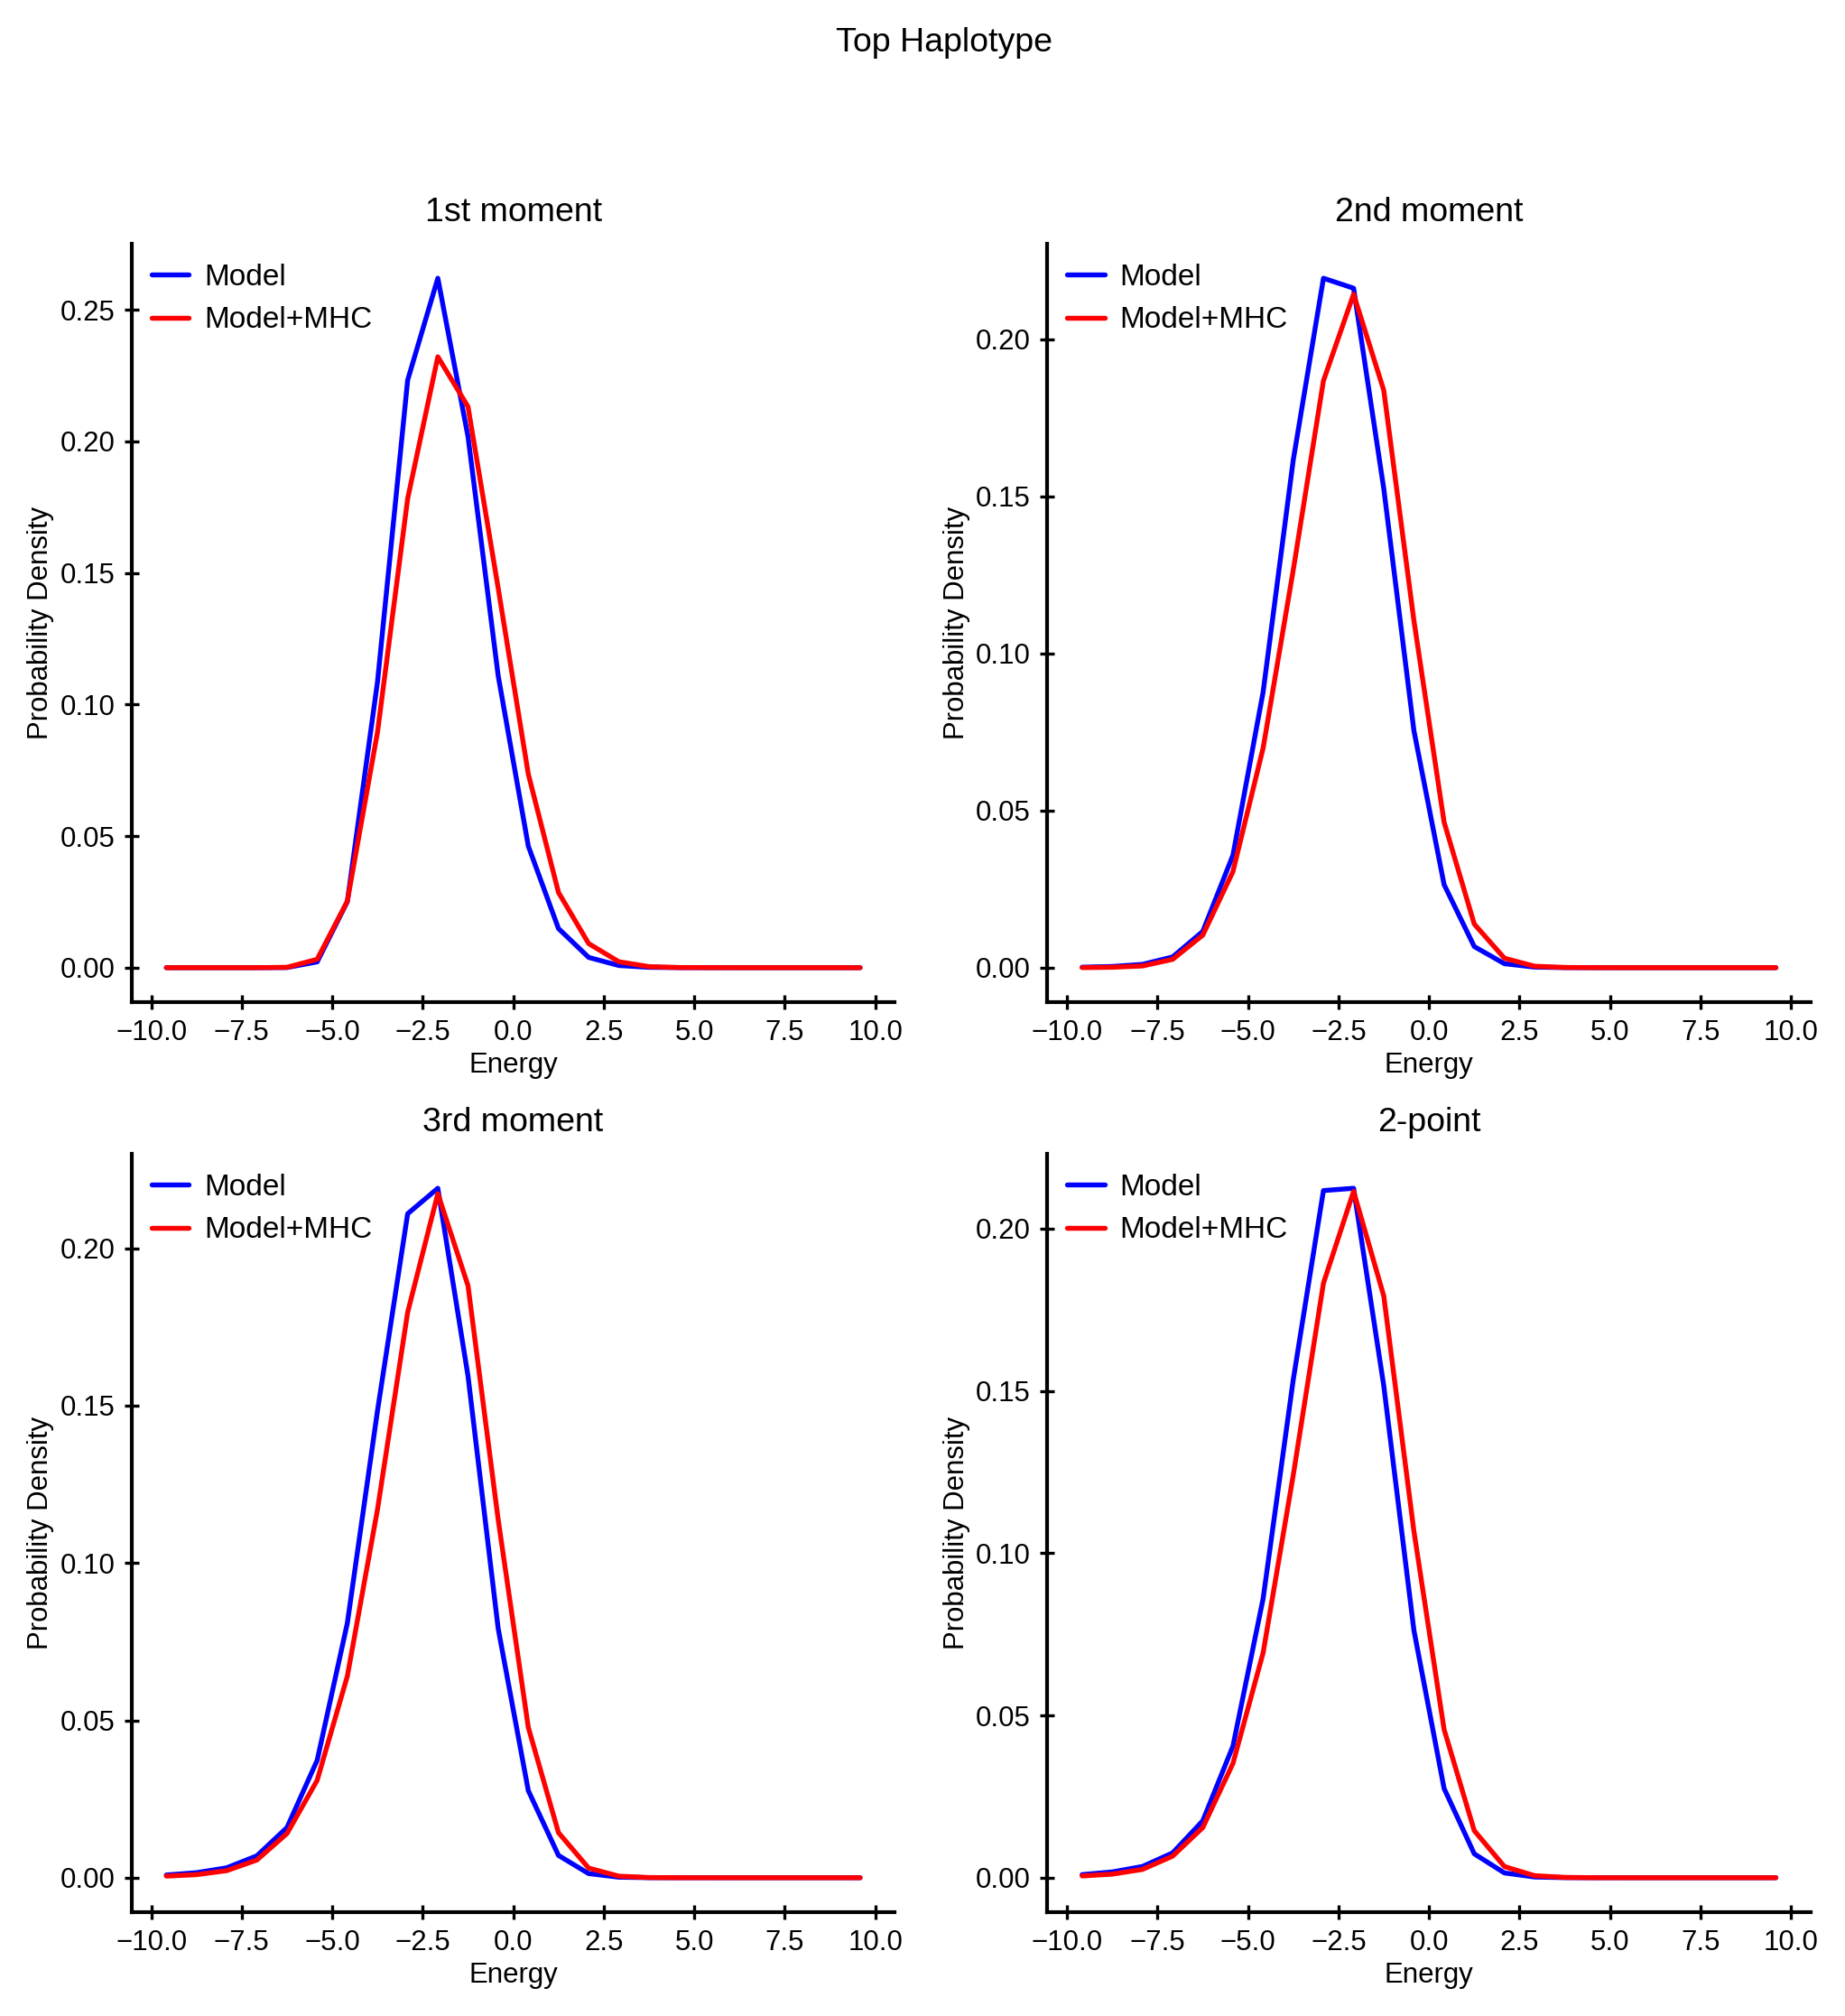

In [97]:
plt.figure(figsize=(8,8))
# fig, axs = plt.subplots(2,2)

model_mapper = {
    "independent": "1st moment",
    "ncov": "2nd moment",
    "nskew": "3rd moment",
    "nskewfcov": "2-point"
}


for i,model in enumerate(model_mapper):

    bins = np.linspace(-10, 10, 25)
    
    plt.subplot(2,2,i+1)
    count, bins_count = np.histogram(top_haplotype_data[model]['energies'],bins=bins)
    pdf = count / sum(count)
    plt.plot(0.5*(bins[:-1]+bins[1:]), pdf, 'b',label='Model')
    
    count, bins_count = np.histogram(top_haplotype_data[model]['energies_mhc'],bins=bins)

    pdf = count / sum(count)
    plt.plot(0.5*(bins[:-1]+bins[1:]), pdf, 'r', label='Model+MHC')
    plt.xlabel('Energy')
    plt.title(model_mapper[model])
    plt.ylabel('Probability Density')
    plt.legend(loc='upper left',fontsize=8)
plt.suptitle('Top Haplotype')
plt.savefig('plots/human_models_and_mhc_energies_top_haplotype.png')

In [14]:
models

['independent', 'ncov', 'nskew', 'nskewfcov']

In [18]:
# save top haplotype data
rows = []
for model in ['uniform', 'independent', 'ncov', 'nskew', 'nskewfcov']:
    
    rows.append({
        'model': model,
        'S': model_s_dict[model][0],
        'S_mhc': model_s_mhc_dict[model][0],
        'pc': model_pc_dict[model][0],
        'pc_mhc': model_pc_mhc_dict[model][0],
        'b': model_pct_binder_dict[model][0]
    })
top_hap_df=pd.DataFrame(data=rows)

In [21]:
top_hap_df

,model,S,S_mhc,pc,pc_mhc,b
0,uniform,26.961590,24.265200,2.080000e-12,2.198144e-11,0.067448
1,independent,26.044667,23.182385,9.840001e-12,1.910495e-10,0.043409
2,ncov,25.923623,23.153121,3.000000e-11,3.254925e-10,0.045030
3,nskew,25.877727,23.127706,8.122201e-10,1.067344e-09,0.045400
4,nskewfcov,25.825689,23.065583,1.082480e-09,1.141353e-09,0.045856


In [22]:
top_hap_df.to_csv(f'{fig_data_path}/top_hap_data.csv')

# netMHC effects on coincidence

## Top 15 Alleles Analysis

In [44]:
a_alleles = ["HLA-A0301", "HLA-A1101", "HLA-A0206", "HLA-A0203", "HLA-A0201"]
b_alleles = ["HLA-B5801", "HLA-B0801", "HLA-B3501", "HLA-B0702", "HLA-B1501"]
c_alleles = ["HLA-C0702", "HLA-C0602", "HLA-C0303", "HLA-C1203", "HLA-C1402"]

top_alleles = a_alleles + b_alleles + c_alleles

In [7]:
haplotypes = list(itertools.product(itertools.combinations_with_replacement(a_alleles,2), itertools.combinations_with_replacement(b_alleles,2),
        itertools.combinations_with_replacement(c_alleles,2)))

In [19]:
sample_haps = random.sample(haplotypes, 5)

In [43]:
def get_mhc_df(model, allele):
    try:
        return pd.read_csv(f'data/netMHC_output/net_mhc_output_thermo_{model}-{allele}.csv')
    except Exception as e:
        print(f'Missing CSV: {model},{allele}')
        return None
        
def get_combined_binders(model, alleles):

    kmers = set()
    for allele in alleles:
        print(allele)
        mhc_df = get_mhc_df(model, allele)
        if mhc_df is not None:
            kmers = kmers.union(set(mhc_df['Peptide']))
    return kmers

In [46]:
proteome = 'Human'
models = ['independent', 'ncov', 'nskew', 'nskewfcov']
n = "1e7"
t = "9"
k=9


sampler = {
            'pc' : {},
            'S': {},
            'N': {},
            'energies': {},
            'pct_binders': {}
}

for model in models:
    print(f'model: {model}')
    energy = make_energy(np.load(f'data/{proteome}_{model}_k{k}_params.npz'))
    F = float(pd.read_csv(f"data/mcmc_thermo/{proteome}_{model}_{n}_{t}_entropy.csv",header=None, index_col=0).loc['F'].values[0])
    
    loglikelihood  = lambda seq: -energy(seq) + F
    
    matrix = load_matrix(f"data/mcmc_thermo/{proteome}_{model}_{n}_{t}_matrix.csv.gz")

    

    binders = get_combined_binders(model, top_alleles)
    kmers = matrix_to_kmers(matrix)
    kmers_mhc = [km for km in kmers if km in binders]
    matrix_mhc = kmers_to_matrix(kmers_mhc)

    sampler['N'][model] = matrix_mhc.shape[0]

    sampler['pct_binders'][model] = matrix_mhc.shape[0]/matrix.shape[0]
    
    coincidence_empirical = calc_coincidence_prob(matrix_mhc)
    sampler['pc'][model] = compute_pc(matrix_mhc)
    logp = np.array([loglikelihood(row) for row in matrix_mhc])

    energies = [energy(x) for x in matrix_mhc]
    sampler['energies'][model] = energies
    sampler['S'][model] = np.mean(np.array(energies)) - F    

data[f"MHC_top_Human_{n}_{t}"] = sampler


model: independent
HLA-A0301
HLA-A1101
HLA-A0206
HLA-A0203
HLA-A0201
HLA-B5801
HLA-B0801
HLA-B3501
HLA-B0702
HLA-B1501
HLA-C0702
HLA-C0602
HLA-C0303
HLA-C1203
HLA-C1402
model: ncov
HLA-A0301
HLA-A1101
HLA-A0206
HLA-A0203
HLA-A0201
HLA-B5801
HLA-B0801
HLA-B3501
HLA-B0702
HLA-B1501
HLA-C0702
HLA-C0602
HLA-C0303
HLA-C1203
HLA-C1402
model: nskew
HLA-A0301
HLA-A1101
HLA-A0206
HLA-A0203
HLA-A0201
HLA-B5801
HLA-B0801
HLA-B3501
HLA-B0702
HLA-B1501
HLA-C0702
HLA-C0602
HLA-C0303
HLA-C1203
HLA-C1402
model: nskewfcov
HLA-A0301
HLA-A1101
HLA-A0206
HLA-A0203
HLA-A0201
HLA-B5801
HLA-B0801
HLA-B3501
HLA-B0702
HLA-B1501
HLA-C0702
HLA-C0602
HLA-C0303
HLA-C1203
HLA-C1402


In [47]:
proteome = 'Human'
models = ['independent', 'ncov', 'nskew', 'nskewfcov']

n = "1e7"
t = "9"
k=9

per_alele_data = {}

for model in models:
    print(f'model: {model}')
    
    per_alele_data[model] = {}
    
    matrix = load_matrix(f"data/mcmc_thermo/{proteome}_{model}_{n}_{t}_matrix.csv.gz")

    
    for allele in top_alleles:
        binders = get_combined_binders(model, [allele])
        kmers = matrix_to_kmers(matrix)
        kmers_mhc = [km for km in kmers if km in binders]
        matrix_mhc = kmers_to_matrix(kmers_mhc)


        per_alele_data[model][f'pct_binders_{allele}'] = matrix_mhc.shape[0]/matrix.shape[0]
       

model: independent
HLA-A0301
HLA-A1101
HLA-A0206
HLA-A0203
HLA-A0201
HLA-B5801
HLA-B0801
HLA-B3501
HLA-B0702
HLA-B1501
HLA-C0702
HLA-C0602
HLA-C0303
HLA-C1203
HLA-C1402
model: ncov
HLA-A0301
HLA-A1101
HLA-A0206
HLA-A0203
HLA-A0201
HLA-B5801
HLA-B0801
HLA-B3501
HLA-B0702
HLA-B1501
HLA-C0702
HLA-C0602
HLA-C0303
HLA-C1203
HLA-C1402
model: nskew
HLA-A0301
HLA-A1101
HLA-A0206
HLA-A0203
HLA-A0201
HLA-B5801
HLA-B0801
HLA-B3501
HLA-B0702
HLA-B1501
HLA-C0702
HLA-C0602
HLA-C0303
HLA-C1203
HLA-C1402
model: nskewfcov
HLA-A0301
HLA-A1101
HLA-A0206
HLA-A0203
HLA-A0201
HLA-B5801
HLA-B0801
HLA-B3501
HLA-B0702
HLA-B1501
HLA-C0702
HLA-C0602
HLA-C0303
HLA-C1203
HLA-C1402


In [20]:
with open('data/human_model_sampling_analysis.json', 'w') as fp:
    json.dump(data, fp)

In [77]:
# load data if starting here
with open('data/human_model_sampling_analysis.json', 'r') as fp:
    data = json.load(fp)

In [67]:
with open('data/human_model_thinning_analysis.json', 'w') as fp:
    json.dump(thinning_data, fp)

In [3]:
with open('data/human_model_thinning_analysis.json', 'r') as fp:
    thinning_data = json.load(fp)

/scratch/lsftmp/8788288.tmpdir/ipykernel_41535/4134664991.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best')


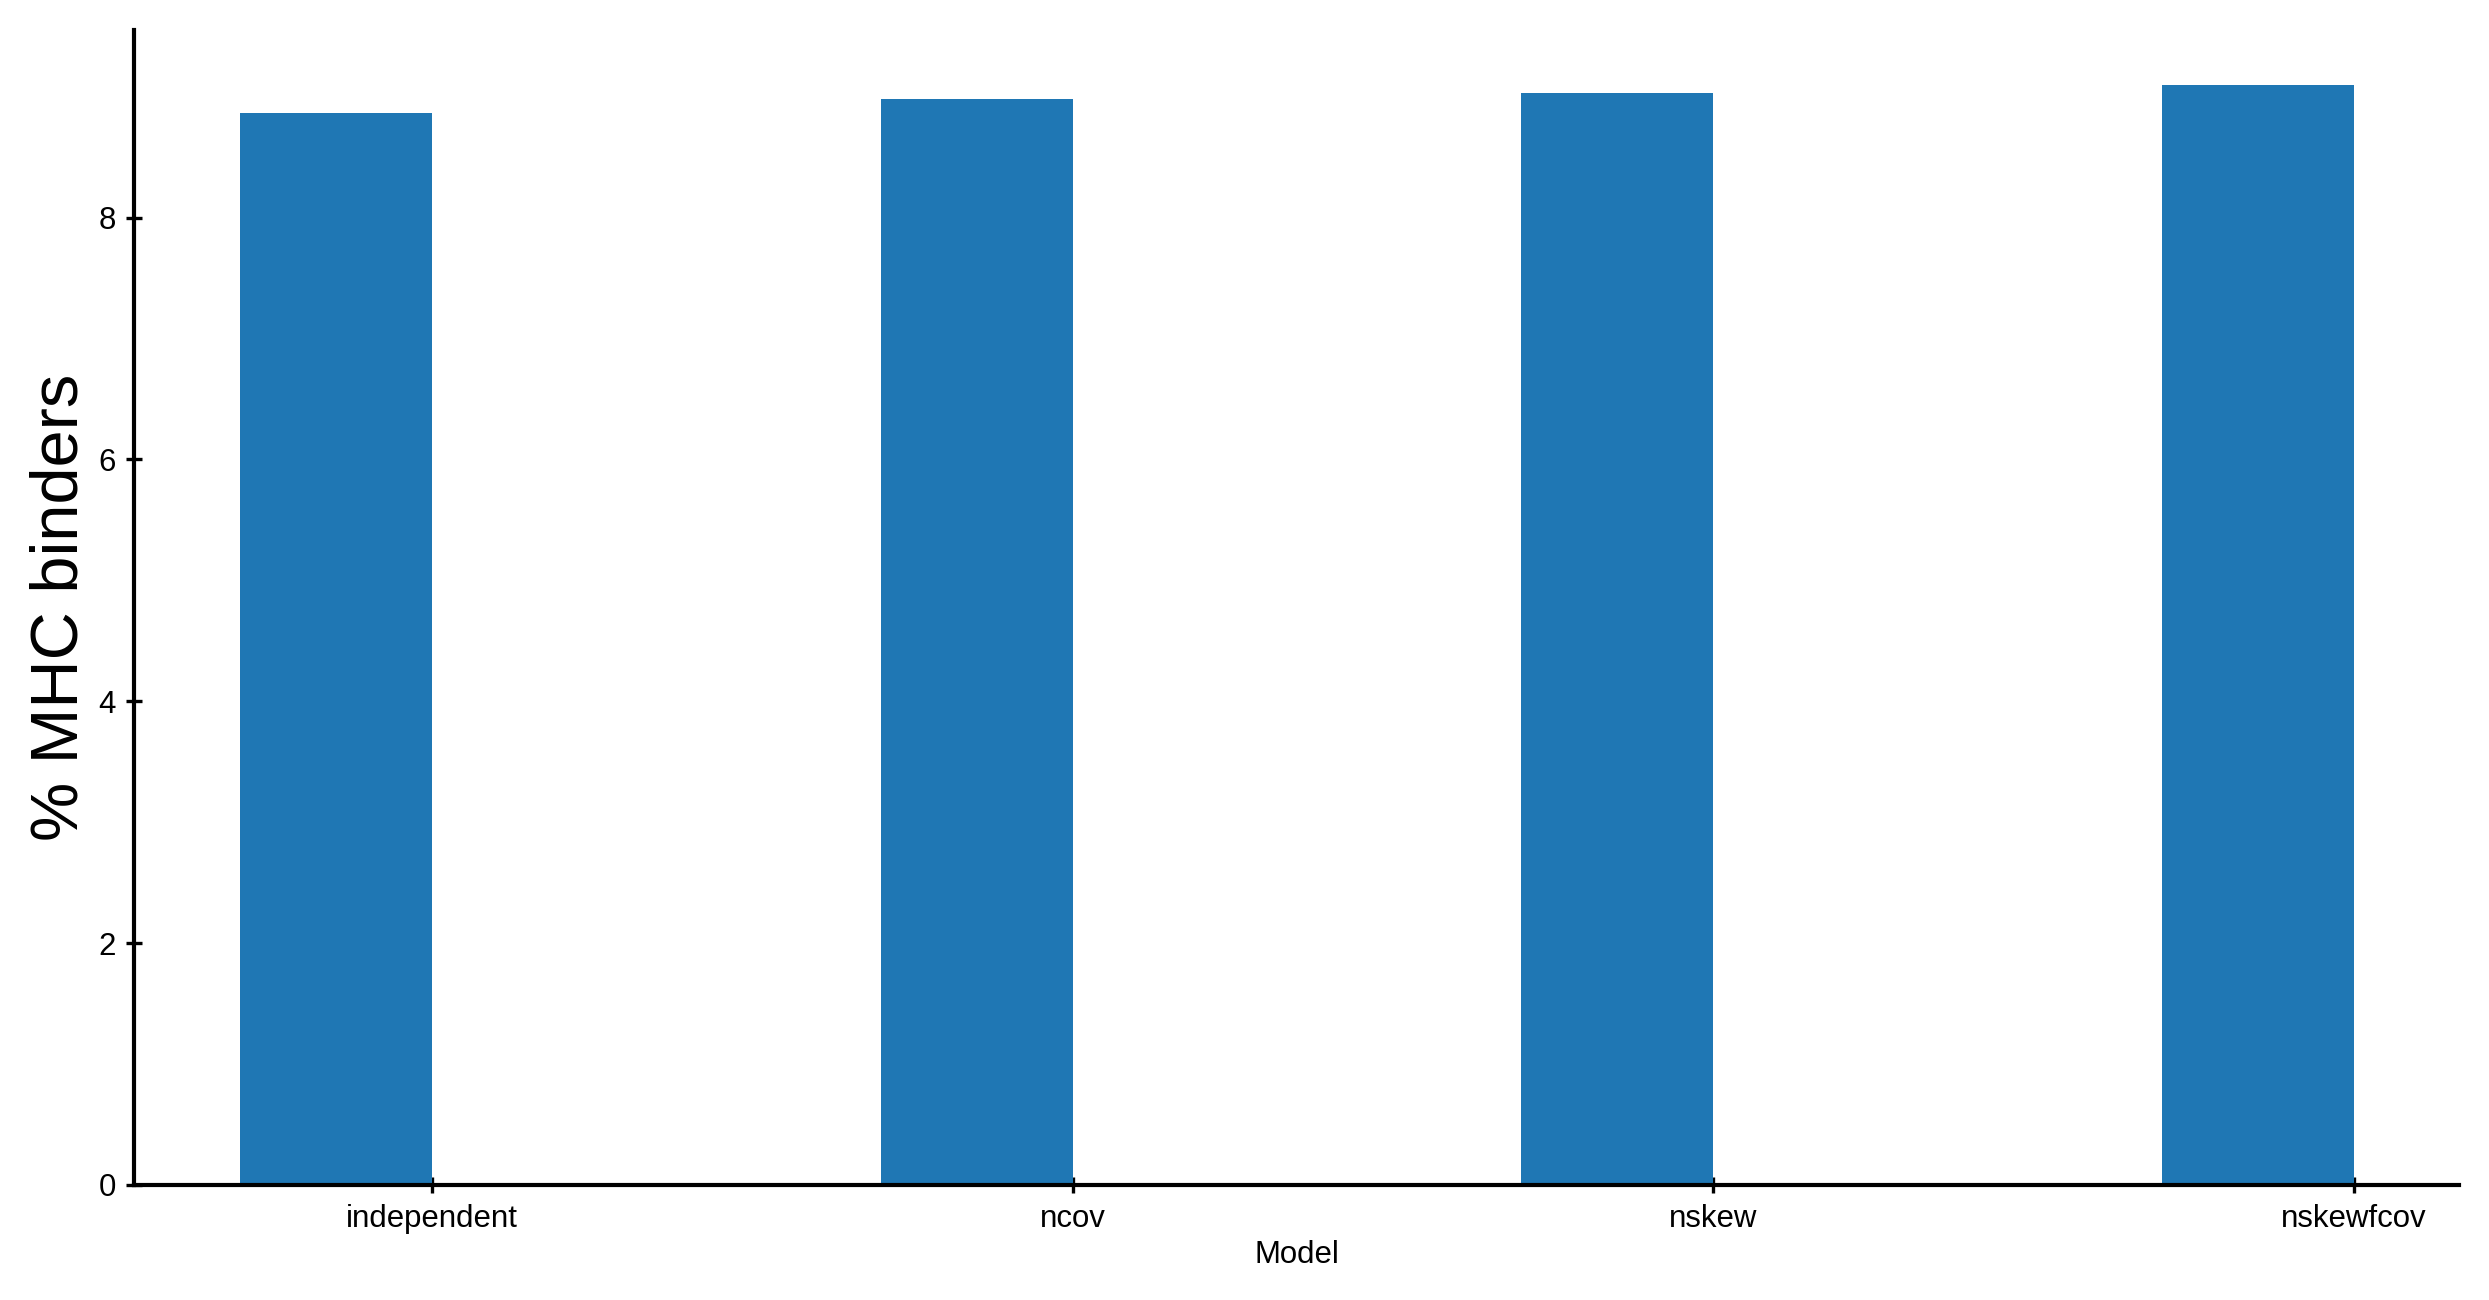

In [4]:
# percent binders
n = "1e7"
t = "9"
relevant_data = data[f"MHC_top_Human_{n}_{t}"]
models = ['independent', 'ncov', 'nskew', 'nskewfcov']
N = len(models)
data_all = [100*relevant_data["pct_binders"][model] for model in models]

ind = np.arange(N)
plt.figure(figsize=(10,5))
width = 0.3       
plt.bar(ind, data_all,width)
plt.xlabel('Model')
plt.ylabel('% MHC binders',fontsize=16)
plt.xticks(ind + width / 2, models)
plt.legend(loc='best')
plt.show()

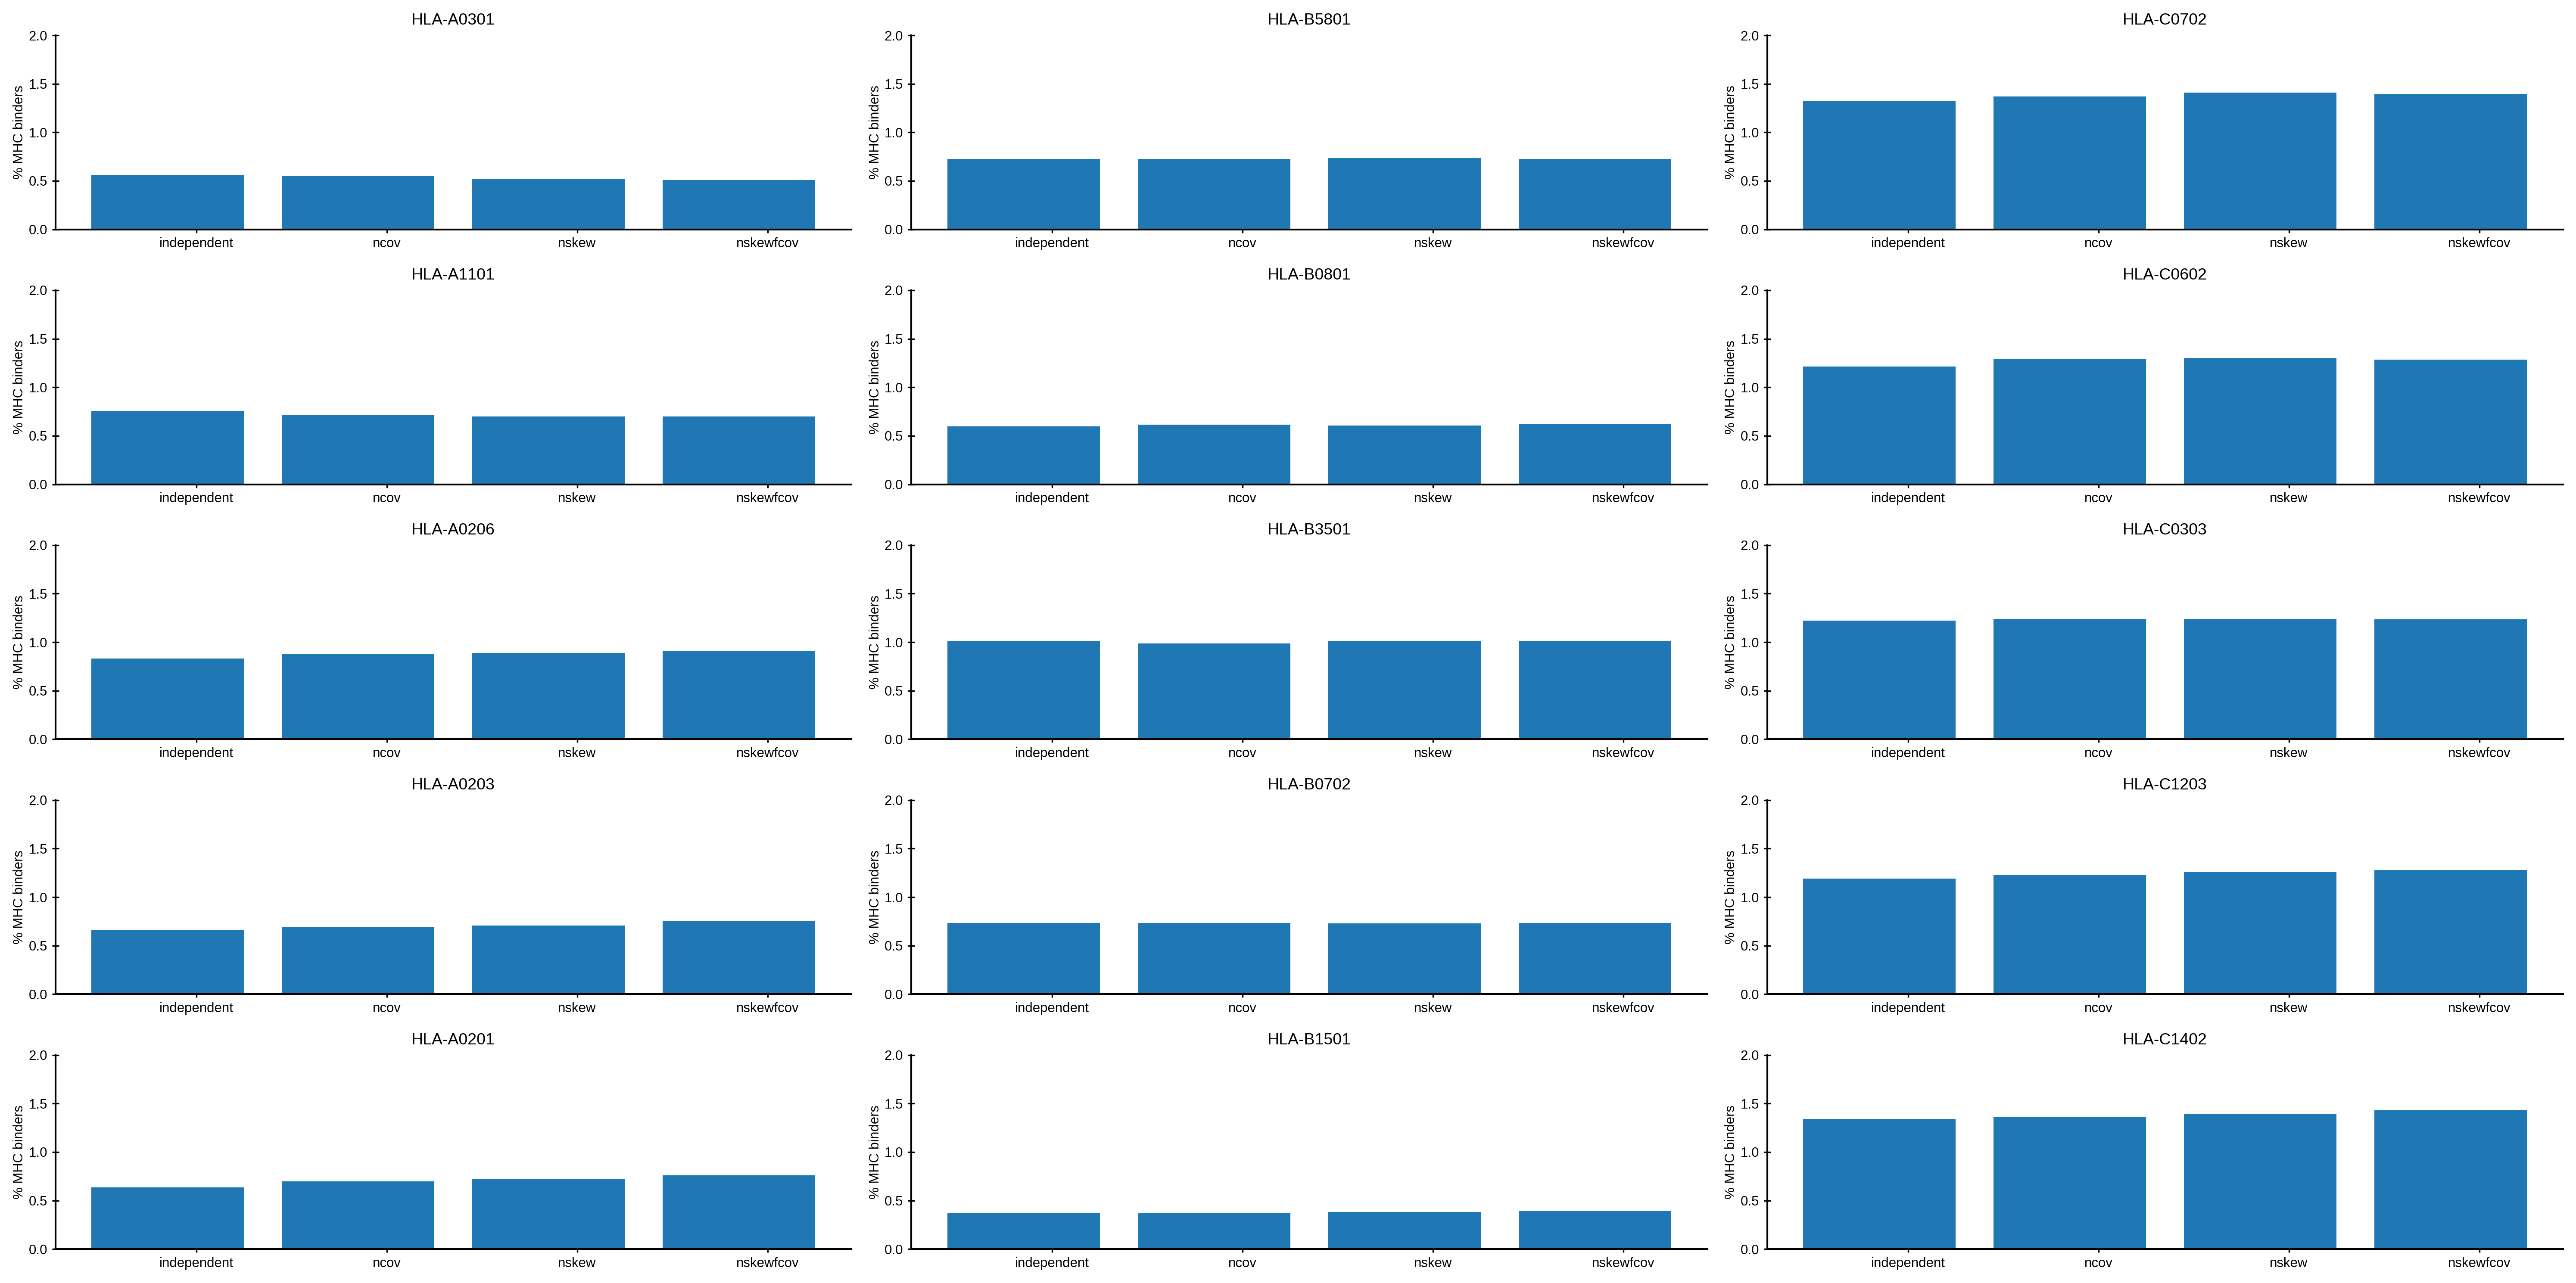

In [58]:
models = ['independent', 'ncov', 'nskew', 'nskewfcov']
model_mappper = {
    "independent": "1st moment",
    "ncov": "2nd moment",
    "nskew": "3rd moment",
    "nskewfcov": "2-point"
}

fig,axes = plt.subplots(nrows=5,ncols=3,figsize=(20,10))
for i,allele in enumerate(top_alleles):
    
    if allele.startswith("HLA-A"):
        col = 0
    elif allele.startswith("HLA-B"):
        col = 1
    else: 
        col = 2
        
    row = i % 5
    
    data = [100*per_alele_data[model][f'pct_binders_{allele}']for model in models]
    N = len(models)
    ind = np.arange(N)
    ax = axes[row, col]
    ax.bar(ind, data)
#     ax.set_xlabel('Model')
    ax.set_ylabel('% MHC binders')
    ax.set_ylim([0,2])
    ax.set_xticks(ind + width / 2, models)
    ax.set_title(allele)
fig.tight_layout()
plt.savefig('plots/percent_binders_by_allele.png')

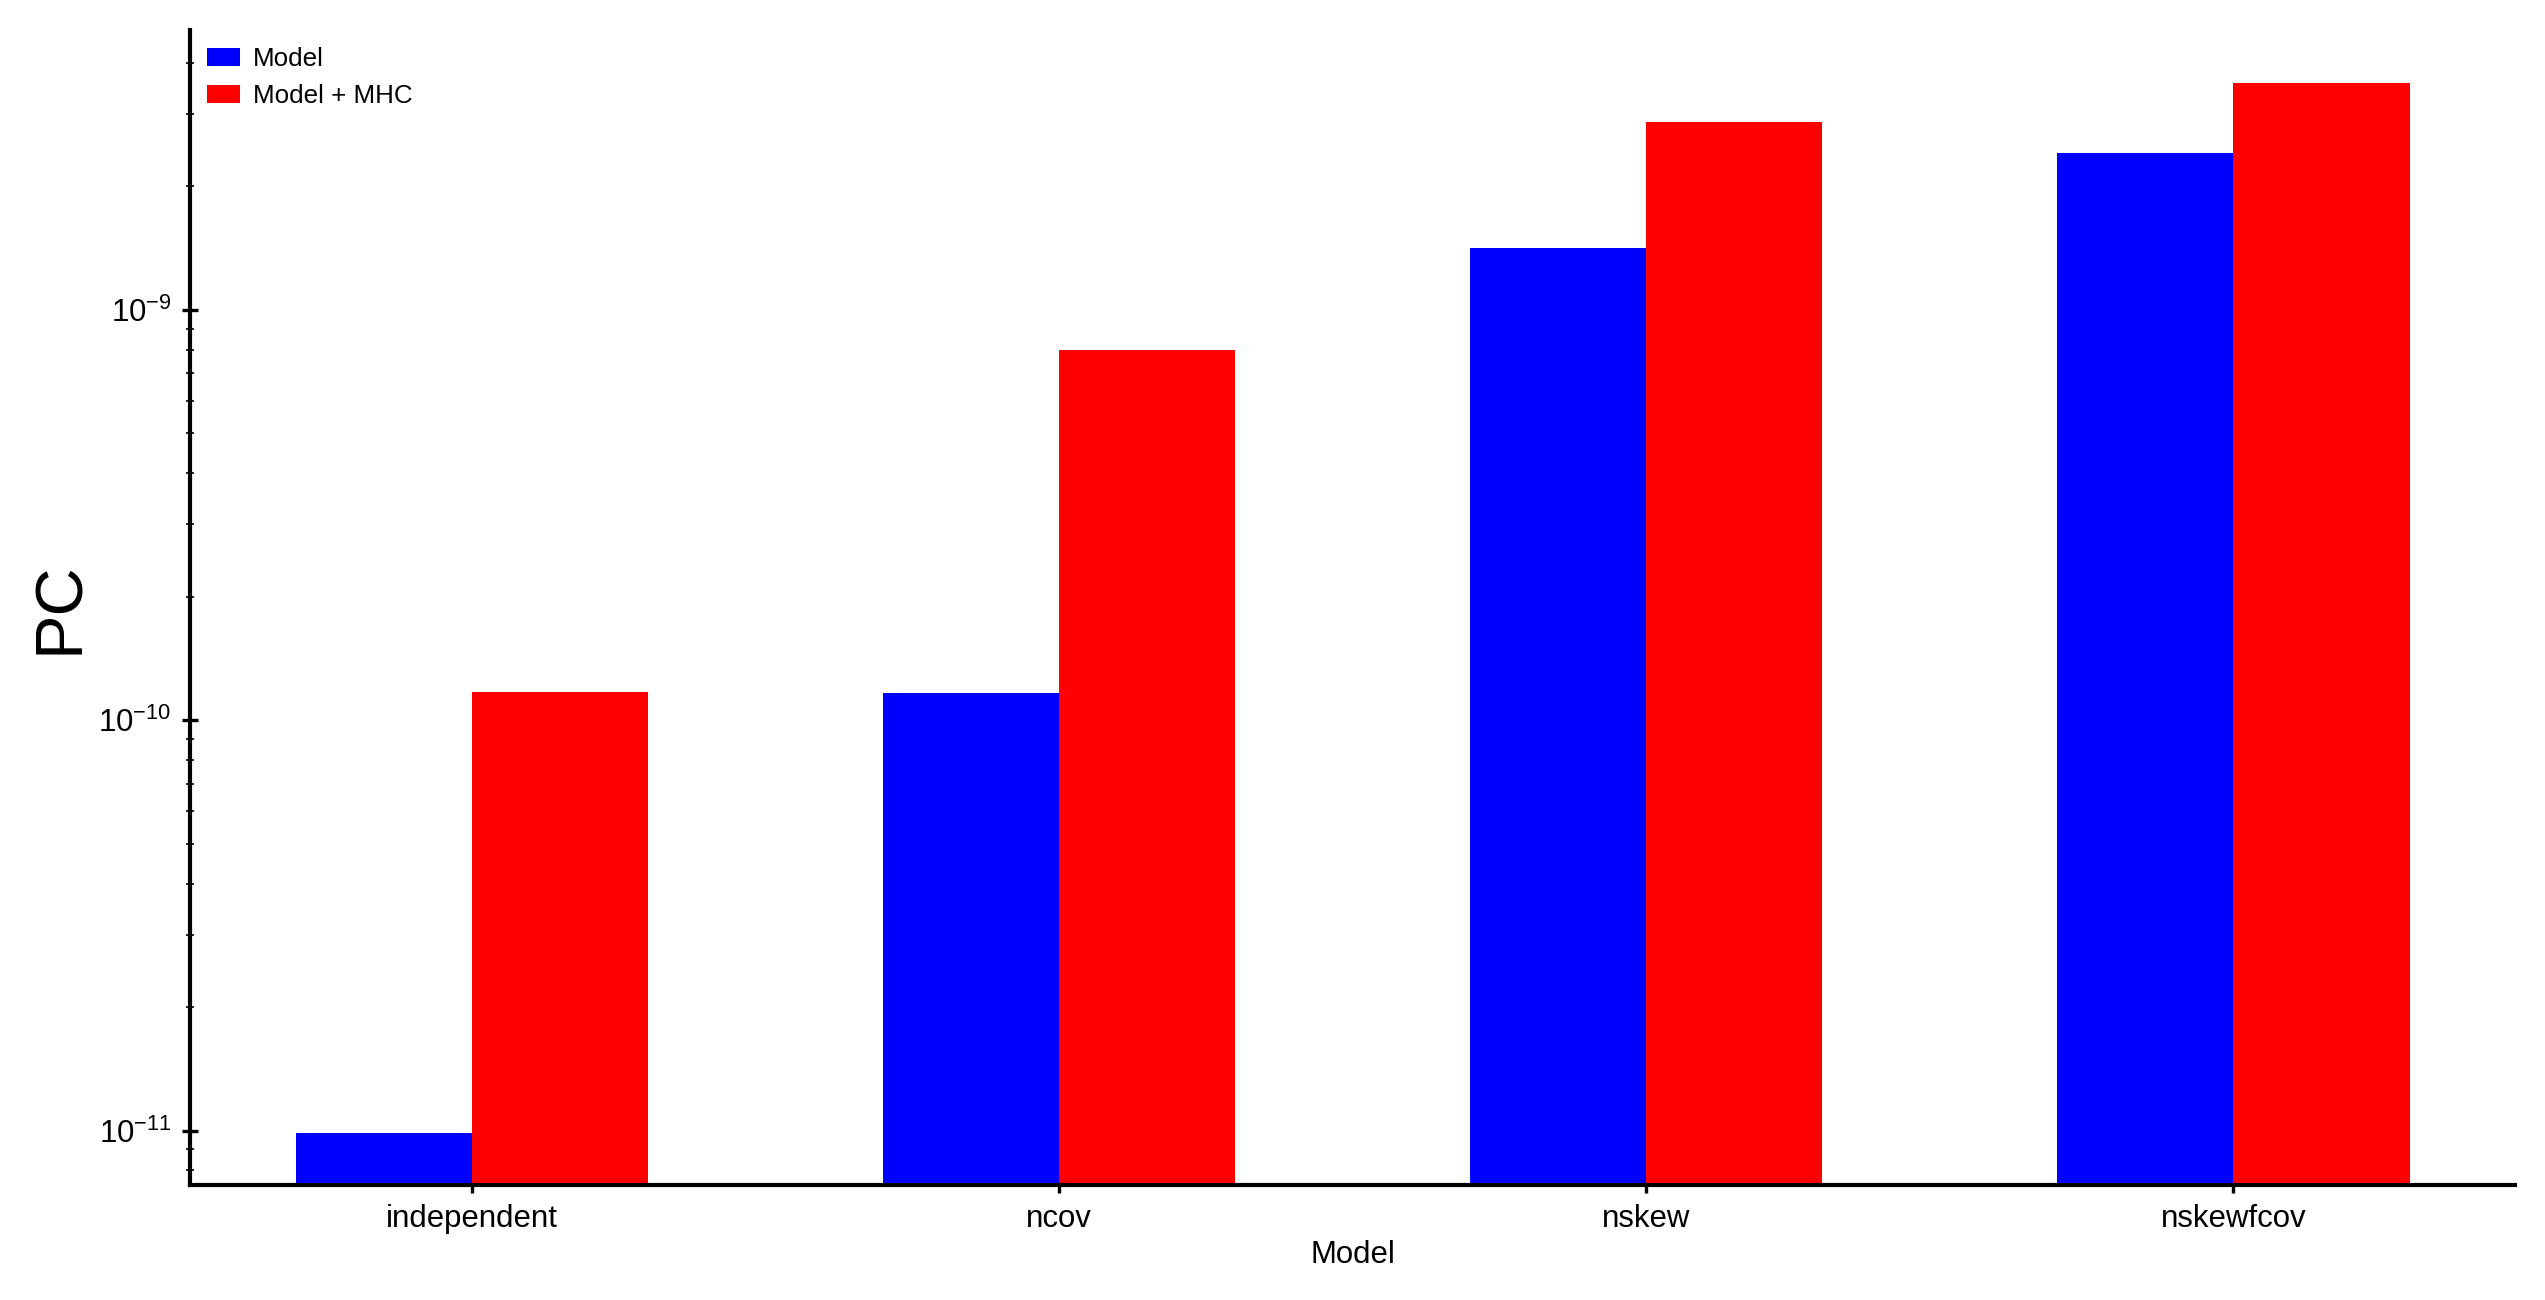

In [57]:
# pc
n = "1e7"
t = "9"

models = ['independent', 'ncov', 'nskew', 'nskewfcov']
N = len(models)

mhc_sample = data[f"MHC_top_Human_{n}_{t}"]
data_mhc = [mhc_sample["pc"][model] for model in models]

all_sample =  data[f"Human_{n}_{t}"]
data_all = [all_sample["pc"][model] for model in models]

ind = np.arange(N)
plt.figure(figsize=(10,5))
width = 0.3       
plt.bar(ind, data_all,width, label='Model',color='blue')
plt.bar(ind + width, data_mhc, width, label='Model + MHC',color='red')
plt.yscale('log')
plt.xlabel('Model')
plt.ylabel('PC',fontsize=16)
plt.xticks(ind + width / 2, models)
plt.legend(loc='best')
plt.show()



<>:40: SyntaxWarning: invalid escape sequence '\e'
<>:40: SyntaxWarning: invalid escape sequence '\e'
/scratch/lsftmp/8788288.tmpdir/ipykernel_41535/870391877.py:40: SyntaxWarning: invalid escape sequence '\e'
  ax1.set_ylabel('Effective Diversity\n$\exp(S)/exp(S_{UNIFORM})$')


-0.11
-0.16
-0.20
-0.07
-0.08
-0.14


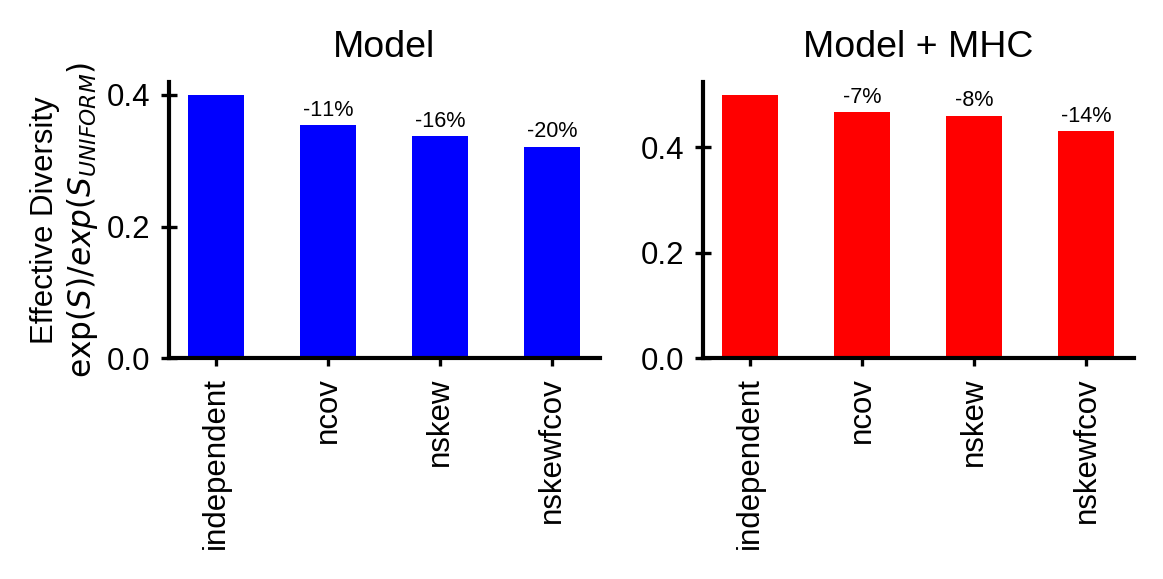

In [101]:
# entropy
k=9
uniform_entropy = np.exp(k*np.log(20))

n = "1e7"
t = "9"

models = ['independent', 'ncov', 'nskew', 'nskewfcov']
N = len(models)

mhc_sample = data[f"MHC_top_Human_{n}_{t}"]
entropies_mhc = np.exp([mhc_sample["S"][model] for model in models])

all_sample =  data[f"Human_{n}_{t}"]
entropies_all = np.exp([all_sample["S"][model] for model in models])


fig, [ax1,ax2] = plt.subplots(1,2,figsize=(4, 2))
ax1.set_title('Model')
ax2.set_title('Model + MHC')

labels = models
width = 0.5 
x = np.arange(len(labels))
rects1 = ax1.bar(x, entropies_all/uniform_entropy, width, color='blue')
ax1.set_xticks(x)
ax1.set_xticklabels(labels, rotation=90)
#ax.axhline(data[1]/data[0], ls='--')

reduction = ((entropies_all[1:]-entropies_all[0])/entropies_all[0])
for rect, toplabel in zip(rects1[1:], reduction):
    print('{0:.2f}'.format(toplabel))
    ax1.annotate('{0:.0f}%'.format(100*toplabel),
                xy=(rect.get_x()+width/2, rect.get_height()),
                xytext=(0, 1),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize='xx-small')


ax1.set_ylabel('Effective Diversity\n$\exp(S)/exp(S_{UNIFORM})$')


ax2.set_xticks(x+width)
ax2.set_xticklabels(labels, rotation=90)

fig.tight_layout()

rects2 = ax2.bar(x+width, entropies_mhc/uniform_entropy, width,color='red')

reduction = ((entropies_mhc[1:]-entropies_mhc[0])/entropies_mhc[0])
for rect, toplabel in zip(rects2[1:], reduction):
    print('{0:.2f}'.format(toplabel))
    ax2.annotate('{0:.0f}%'.format(100*toplabel),
                xy=(rect.get_x()+width/2, rect.get_height()),
                xytext=(0, 1),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize='xx-small')



In [7]:
count = 0
max_count = 10000000
uniform_kmers = []
with open("data/netMHC_input/net_mhc_input_uniform_2x.txt") as f:
    for k in f.readlines():
        count = count + 1
        if count > max_count:
            break
        uniform_kmers.append(k.strip())
uniform_kmers_matrix = kmers_to_matrix(uniform_kmers)

In [57]:
# # repeat because weird result
# random_matrix = model_matrix_random = np.random.choice(np.arange(0, 20, 1), size=(max_count,k))
# kmers = matrix_to_kmers(random_matrix)
# with open("data/netMHC_input/net_mhc_input_uniform_replicate.txt",'w') as f:
#     for item in kmers:
#         f.write(f"{item}\n")

In [59]:
def get_mhc_df(allele):
    try:
        return pd.read_csv(f'data/netMHC_output/net_mhc_output_uniform_2x-{allele}.csv')
    except Exception as e:
        print(f'Missing CSV: {allele}')
        return None
        
def get_combined_binders(alleles):

    kmers = set()
    for allele in alleles:
        print(allele)
        mhc_df = get_mhc_df(allele)
        if mhc_df is not None:
            kmers = kmers.union(set(mhc_df['Peptide']))
    return kmers

In [10]:
k=9
sampler = {}

binders = get_combined_binders(top_alleles)
kmers_mhc = [km for km in uniform_kmers if km in binders]
matrix_mhc = kmers_to_matrix(kmers_mhc)

sampler['N'] = matrix_mhc.shape[0]

sampler['pct_binders'] = matrix_mhc.shape[0]/uniform_kmers_matrix.shape[0]

# coincidence_empirical = calc_coincidence_prob(matrix_mhc)
sampler['pc'] = compute_pc(uniform_kmers_matrix)
sampler['pc_mhc'] = compute_pc(matrix_mhc)
# logp = np.array([loglikelihood(row) for row in matrix_mhc])

# energies = [energy(x) for x in matrix_mhc]
# sampler['energies'][model] = energies
sampler['S'] = np.log((20**k)*sampler['pct_binders'])

data["uniform"] = sampler


HLA-A0301
HLA-A1101
HLA-A0206
HLA-A0203
HLA-A0201
HLA-B5801
HLA-B0801
HLA-B3501
HLA-B0702
HLA-B1501
HLA-C0702
HLA-C0602
HLA-C0303
HLA-C1203
HLA-C1402


In [62]:
def get_mhc_df(allele):
    try:
        return pd.read_csv(f'data/netMHC_output/net_mhc_output_uniform_replicate-{allele}.csv')
    except Exception as e:
        print(f'Missing CSV: {allele}')
        return None
        
def get_combined_binders(alleles):

    kmers = set()
    for allele in alleles:
        print(allele)
        mhc_df = get_mhc_df(allele)
        if mhc_df is not None:
            kmers = kmers.union(set(mhc_df['Peptide']))
    return kmers

In [12]:
k=9
sampler = {}

binders = get_combined_binders(top_alleles)
kmers_mhc = [km for km in uniform_kmers_replicate if km in binders]
matrix_mhc = kmers_to_matrix(kmers_mhc)

sampler['N'] = matrix_mhc.shape[0]

sampler['pct_binders'] = matrix_mhc.shape[0]/uniform_kmers_matrix_replicate.shape[0]

# coincidence_empirical = calc_coincidence_prob(matrix_mhc)
sampler['pc'] = compute_pc(uniform_kmers_matrix)
sampler['pc_mhc'] = compute_pc(matrix_mhc)
# logp = np.array([loglikelihood(row) for row in matrix_mhc])

# energies = [energy(x) for x in matrix_mhc]
# sampler['energies'][model] = energies
sampler['S'] = np.log((20**k)*sampler['pct_binders'])

data["uniform_replicate"] = sampler


HLA-A0301
HLA-A1101
HLA-A0206
HLA-A0203
HLA-A0201
HLA-B5801
HLA-B0801
HLA-B3501
HLA-B0702
HLA-B1501
HLA-C0702
HLA-C0602
HLA-C0303
HLA-C1203
HLA-C1402


In [65]:
k=9

uniform_per_alele_data = {}

    
for allele in top_alleles:
    print(allele)
    binders = get_combined_binders([allele])
    kmers_mhc = [km for km in uniform_kmers_replicate if km in binders]
    matrix_mhc = kmers_to_matrix(kmers_mhc)
    uniform_per_alele_data[f'pct_binders_{allele}'] = matrix_mhc.shape[0]/uniform_kmers_matrix_replicate.shape[0]


HLA-A0301
HLA-A0301
HLA-A1101
HLA-A1101
HLA-A0206
HLA-A0206
HLA-A0203
HLA-A0203
HLA-A0201
HLA-A0201
HLA-B5801
HLA-B5801
HLA-B0801
HLA-B0801
HLA-B3501
HLA-B3501
HLA-B0702
HLA-B0702
HLA-B1501
HLA-B1501
HLA-C0702
HLA-C0702
HLA-C0602
HLA-C0602
HLA-C0303
HLA-C0303
HLA-C1203
HLA-C1203
HLA-C1402
HLA-C1402


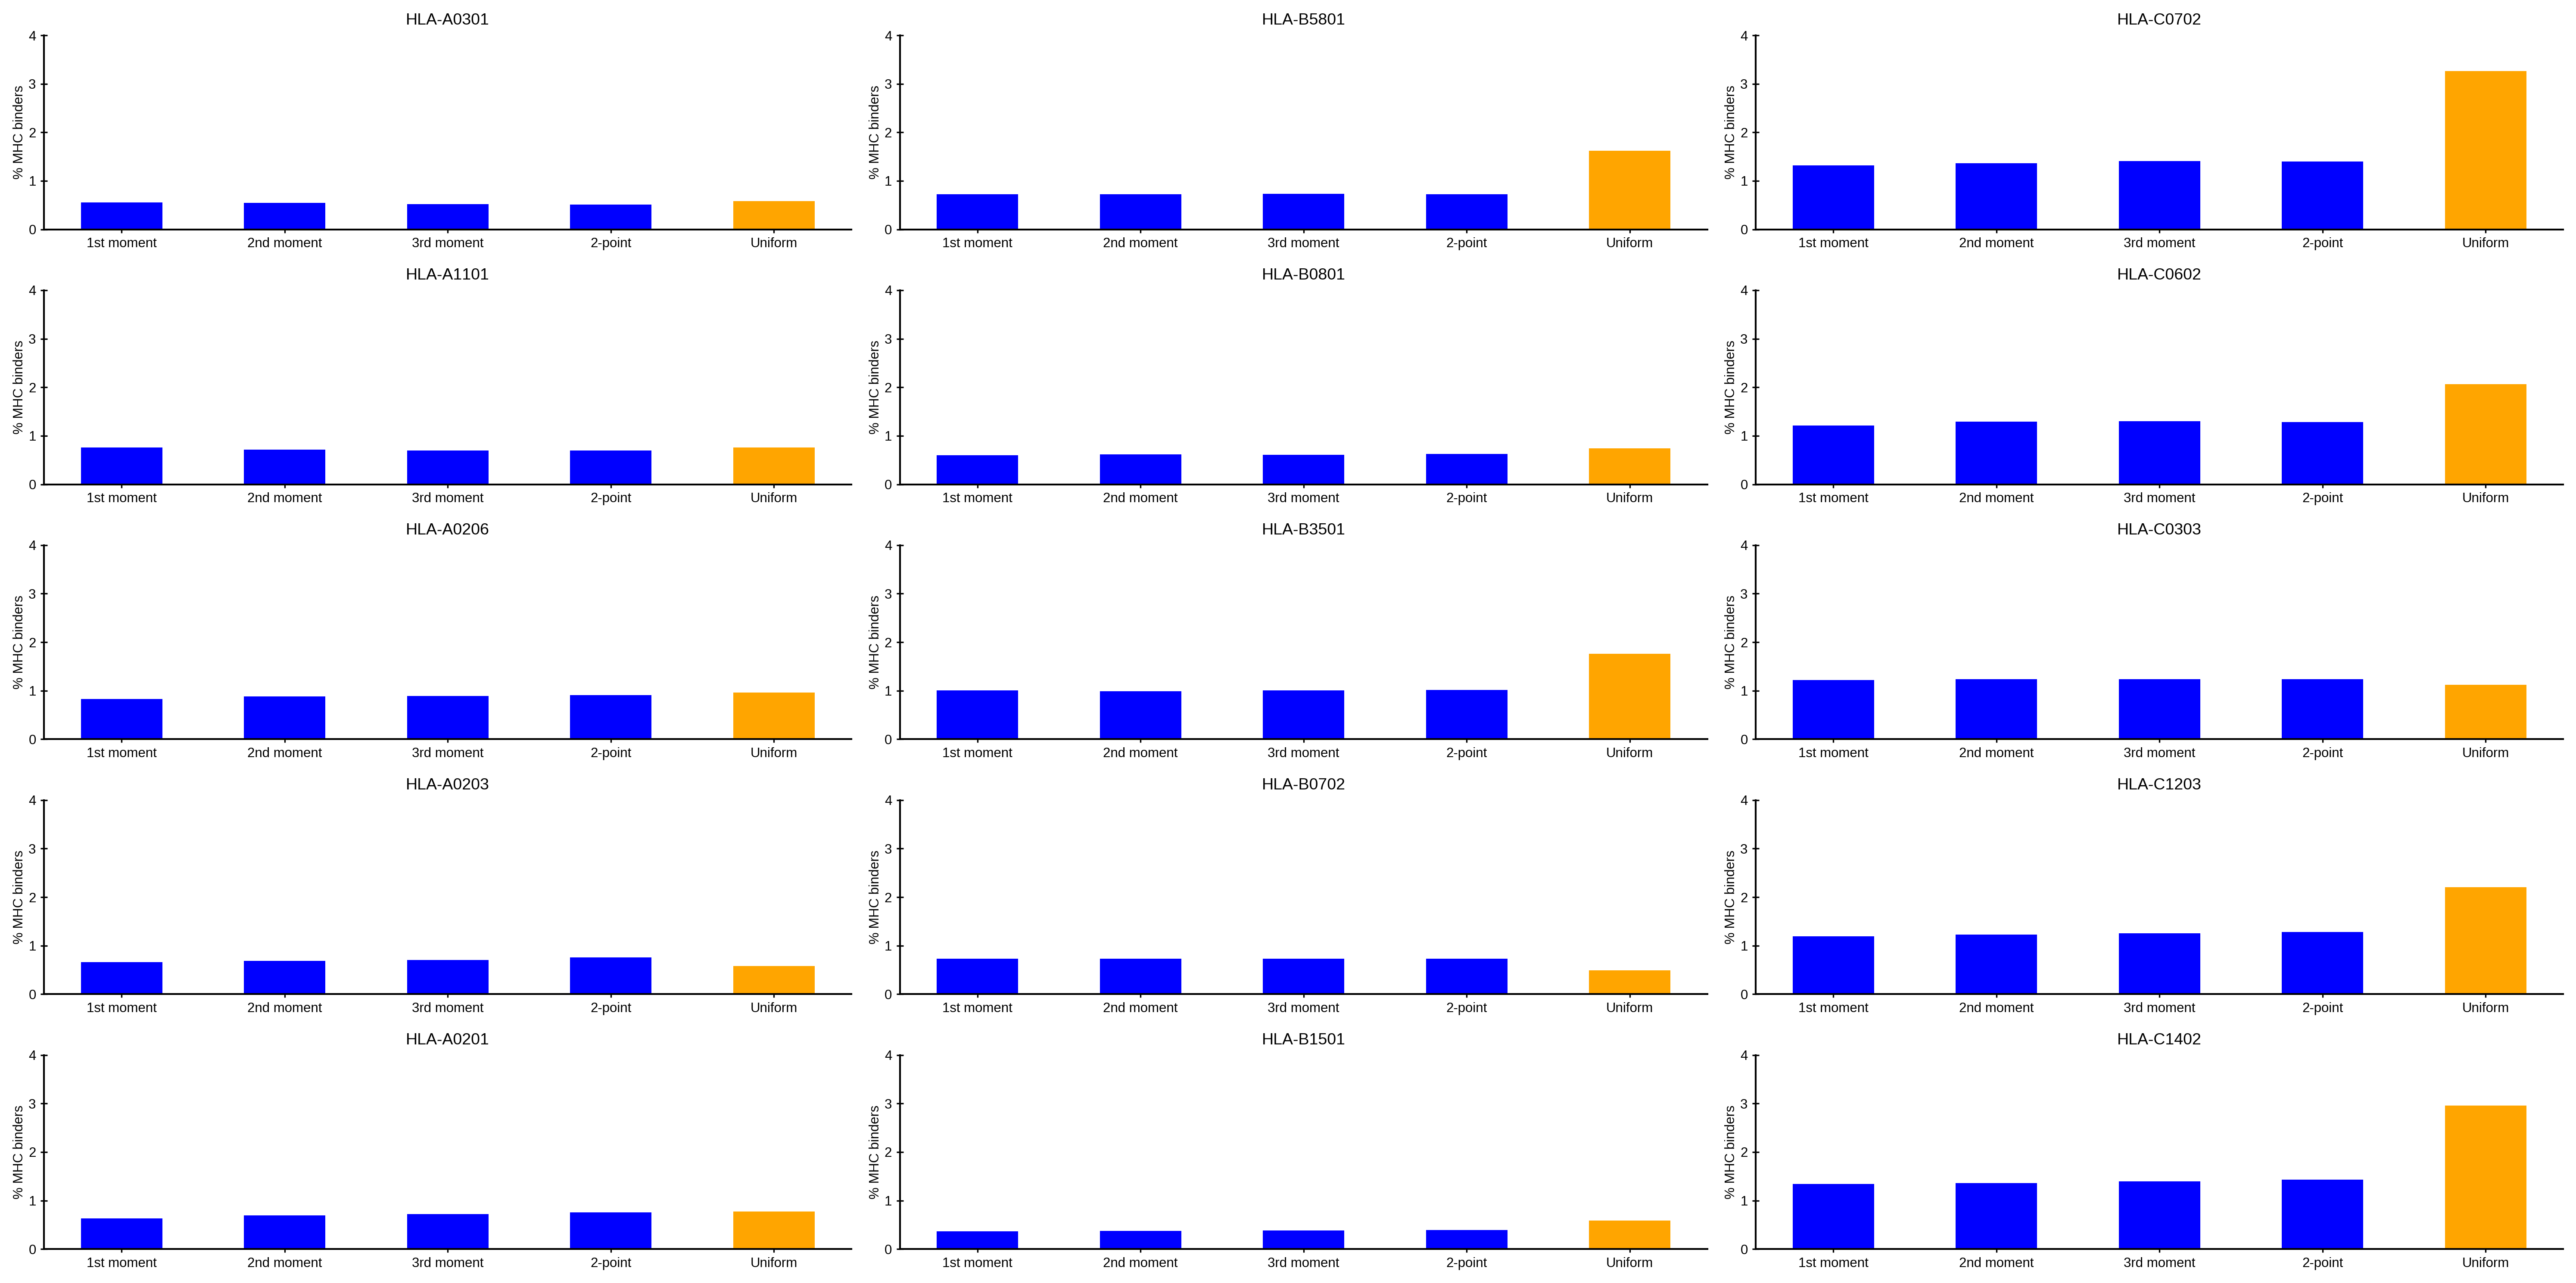

In [75]:
models = ['independent', 'ncov', 'nskew', 'nskewfcov']
model_mappper = {
    "independent": "1st moment",
    "ncov": "2nd moment",
    "nskew": "3rd moment",
    "nskewfcov": "2-point"
}

fig,axes = plt.subplots(nrows=5,ncols=3,figsize=(20,10))
for i,allele in enumerate(top_alleles):
    
    if allele.startswith("HLA-A"):
        col = 0
    elif allele.startswith("HLA-B"):
        col = 1
    else: 
        col = 2
        
    row = i % 5
    
    width = 0.5 
    
    bar_data = [100*per_alele_data[model][f'pct_binders_{allele}']for model in models]
    N = len(models)+1
    ind = np.arange(N)+1
    ax = axes[row, col]
    ax.bar(ind[:-1], bar_data, width, color='blue')
    ax.bar(ind[-1:], 100*uniform_per_alele_data[f'pct_binders_{allele}'], width,color='orange')
#     ax.set_xlabel('Model')
    ax.set_ylabel('% MHC binders')
    ax.set_ylim([0,4])
    ax.set_xticks(ind, list(model_mappper.values())+['Uniform'])
    ax.set_title(allele)
fig.tight_layout()
plt.savefig('plots/percent_binders_by_allele_with_uniform.png')

-0.11
-0.16
-0.20


<>:39: SyntaxWarning: invalid escape sequence '\e'
<>:39: SyntaxWarning: invalid escape sequence '\e'
/scratch/lsftmp/8788288.tmpdir/ipykernel_41535/3225676675.py:39: SyntaxWarning: invalid escape sequence '\e'
  ax1.set_ylabel('Effective Diversity\n$\exp(S)/20^k$')


Text(0, 0.5, 'Effective Diversity\n$\\exp(S)/20^k$')

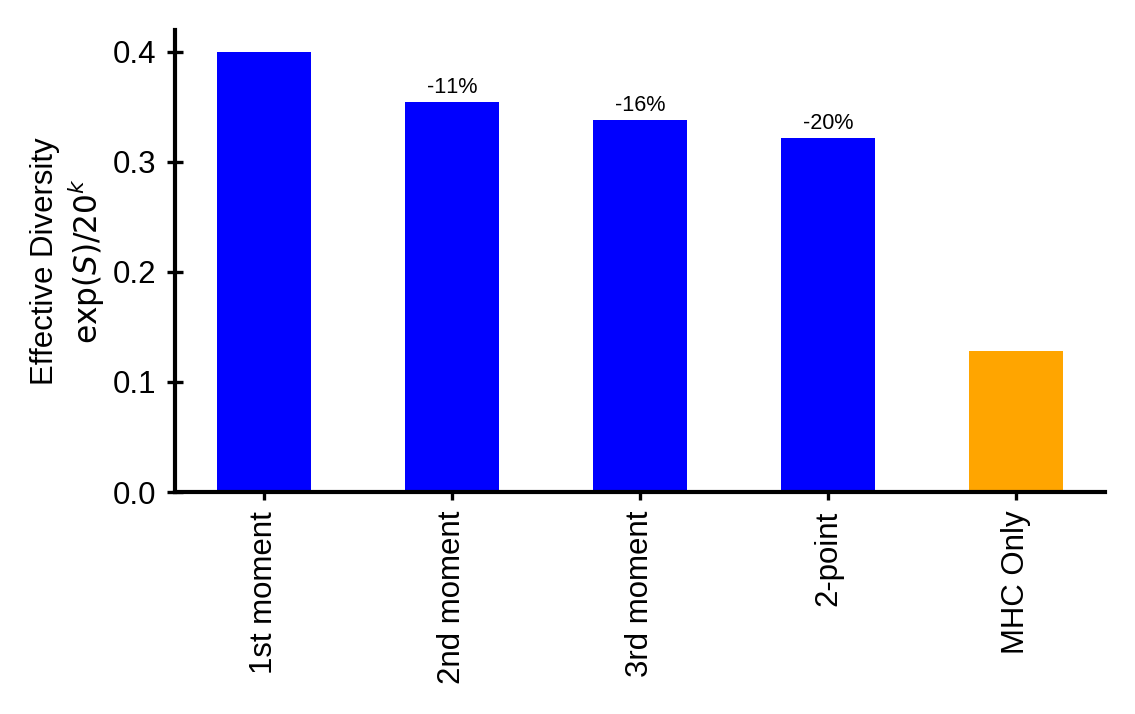

In [61]:
# MHC applied to uniform peptides
# entropy

uniform_entropy = np.exp(k*np.log(20))

n = "1e7"
t = "9"

models = ['independent', 'ncov', 'nskew', 'nskewfcov']
N = len(models)

all_sample =  data[f"Human_{n}_{t}"]
entropies_all = [all_sample["S"][model] for model in models]
entropies_all = entropies_all + [data["uniform"]["S"]]
entropies_all = np.exp(entropies_all)


fig, ax1 = plt.subplots(figsize=(4, 2))

labels = ['1st moment', '2nd moment', '3rd moment', '2-point']
width = 0.5 
x = np.arange(len(labels)+1)
rects1 = ax1.bar(x[:-1], entropies_all[:-1]/uniform_entropy, width, color='blue')
rects2 = ax1.bar(x[-1:], entropies_all[-1:]/uniform_entropy, width, color='orange')
ax1.set_xticks(x)
ax1.set_xticklabels(labels + ['MHC Only'], rotation=90)
#ax.axhline(data[1]/data[0], ls='--')

reduction = ((entropies_all[1:]-entropies_all[0])/entropies_all[0])
for rect, toplabel in zip(rects1[1:], reduction):
    print('{0:.2f}'.format(toplabel))
    ax1.annotate('{0:.0f}%'.format(100*toplabel),
                xy=(rect.get_x()+width/2, rect.get_height()),
                xytext=(0, 1),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize='xx-small')


ax1.set_ylabel('Effective Diversity\n$\exp(S)/20^k$')



In [23]:
np.exp(data["uniform"]["S"])/uniform_entropy

np.float64(0.1275604948505816)

In [25]:
(np.exp(data["uniform"]["S"]))/uniform_entropy

np.float64(0.1275604948505816)

/scratch/lsftmp/9056930.tmpdir/ipykernel_26489/707022337.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(loc='best')


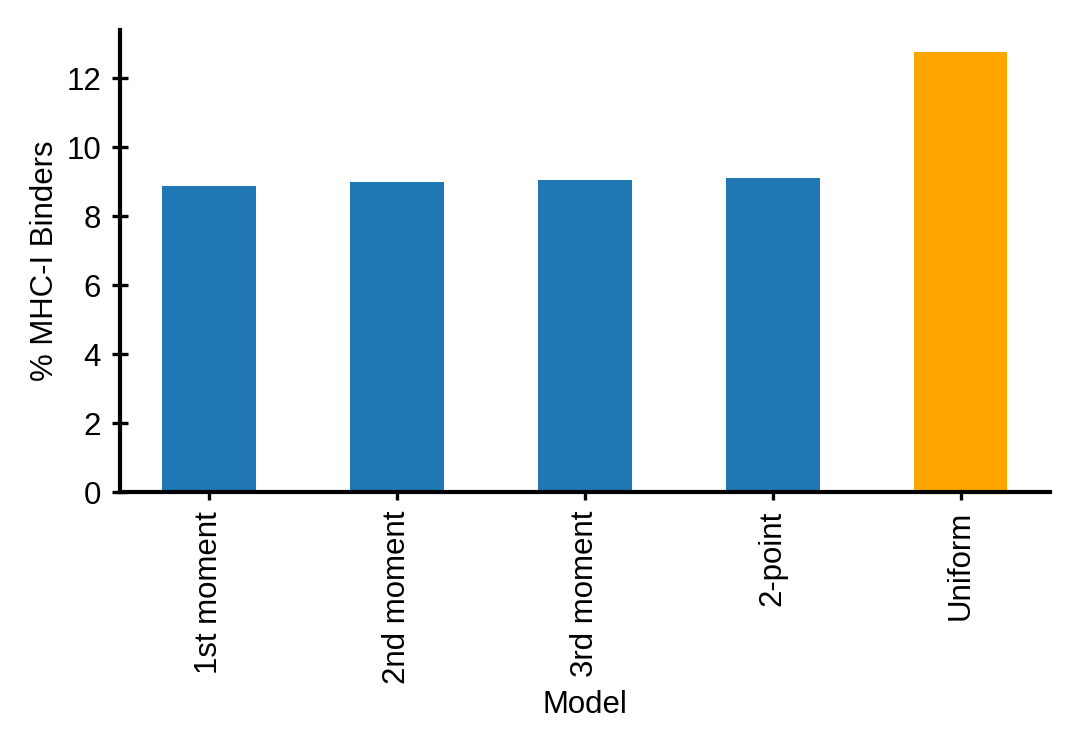

In [10]:
# percent binders


fig, ax1 = plt.subplots(figsize=(4, 2))


n = "1e7"
t = "9"
relevant_data = data[f"MHC_top_Human_{n}_{t}"]
models = ['independent', 'ncov', 'nskew', 'nskewfcov']
N = len(models)+1
data_all = [100*relevant_data["pct_binders"][model] for model in models]
# data_all = data_all + [100*data["uniform"]["pct_binders"]] + [100*data["uniform_replicate"]["pct_binders"]]
data_all = data_all + [100*data["uniform"]["pct_binders"]]



ind = np.arange(N)
width = 0.5       
ax1.bar(ind[:-1], data_all[:-1],width)
ax1.bar(ind[-1:], data_all[-1:],width,color='orange')
ax1.set_xlabel('Model')
ax1.set_ylabel('% MHC-I Binders')
labels = ["1st moment", "2nd moment", "3rd moment", "2-point", "Uniform"]
ax1.set_xticks(ind)
ax1.set_xticklabels(labels, rotation=90)
ax1.legend(loc='best')
plt.savefig('./plots/percent_binders_human.png')

/scratch/lsftmp/8788288.tmpdir/ipykernel_41535/488077044.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best')


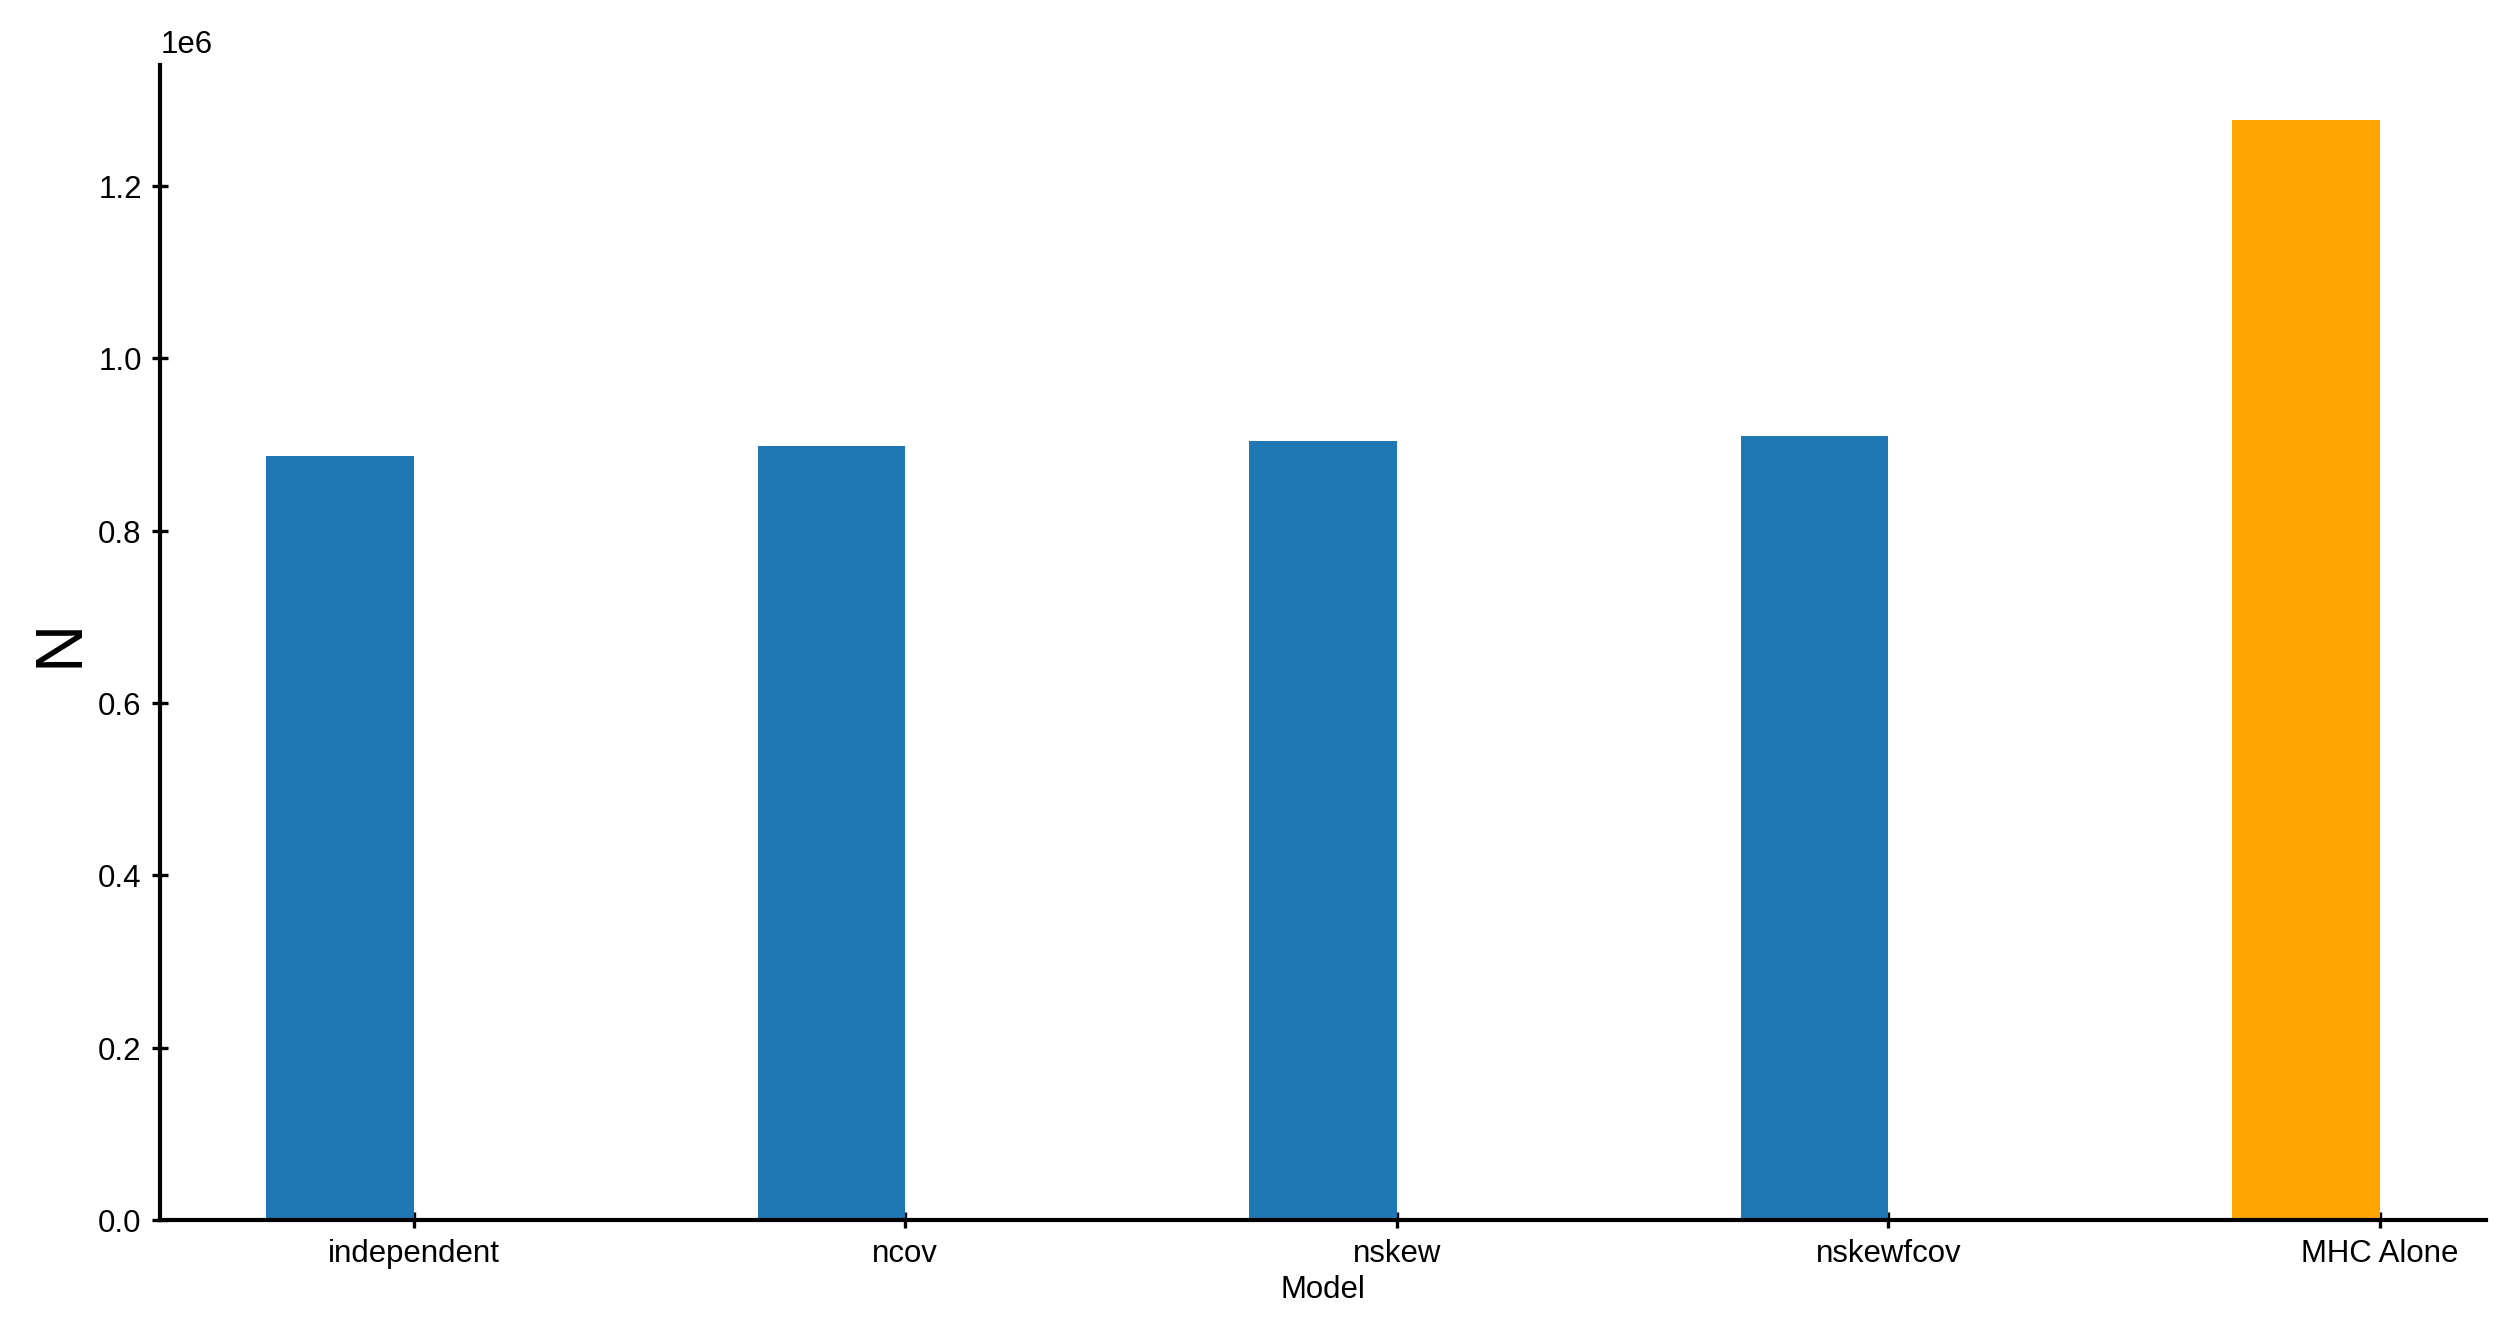

In [52]:
# percent binders
n = "1e7"
t = "9"
relevant_data = data[f"MHC_top_Human_{n}_{t}"]
models = ['independent', 'ncov', 'nskew', 'nskewfcov']
N = len(models)+1
data_all = [relevant_data["N"][model] for model in models]
data_all = data_all + [data["uniform"]["N"]]

ind = np.arange(N)
plt.figure(figsize=(10,5))
width = 0.3       
plt.bar(ind[:-1], data_all[:-1],width)
plt.bar(ind[-1:], data_all[-1:],width,color='orange')
plt.xlabel('Model')
plt.ylabel('N',fontsize=16)
plt.xticks(ind + width / 2, models+["MHC Alone"])
plt.legend(loc='best')
plt.show()

In [50]:
data_all

[8.86516, 8.98371, 9.03491, 9.09714, 12.76559]

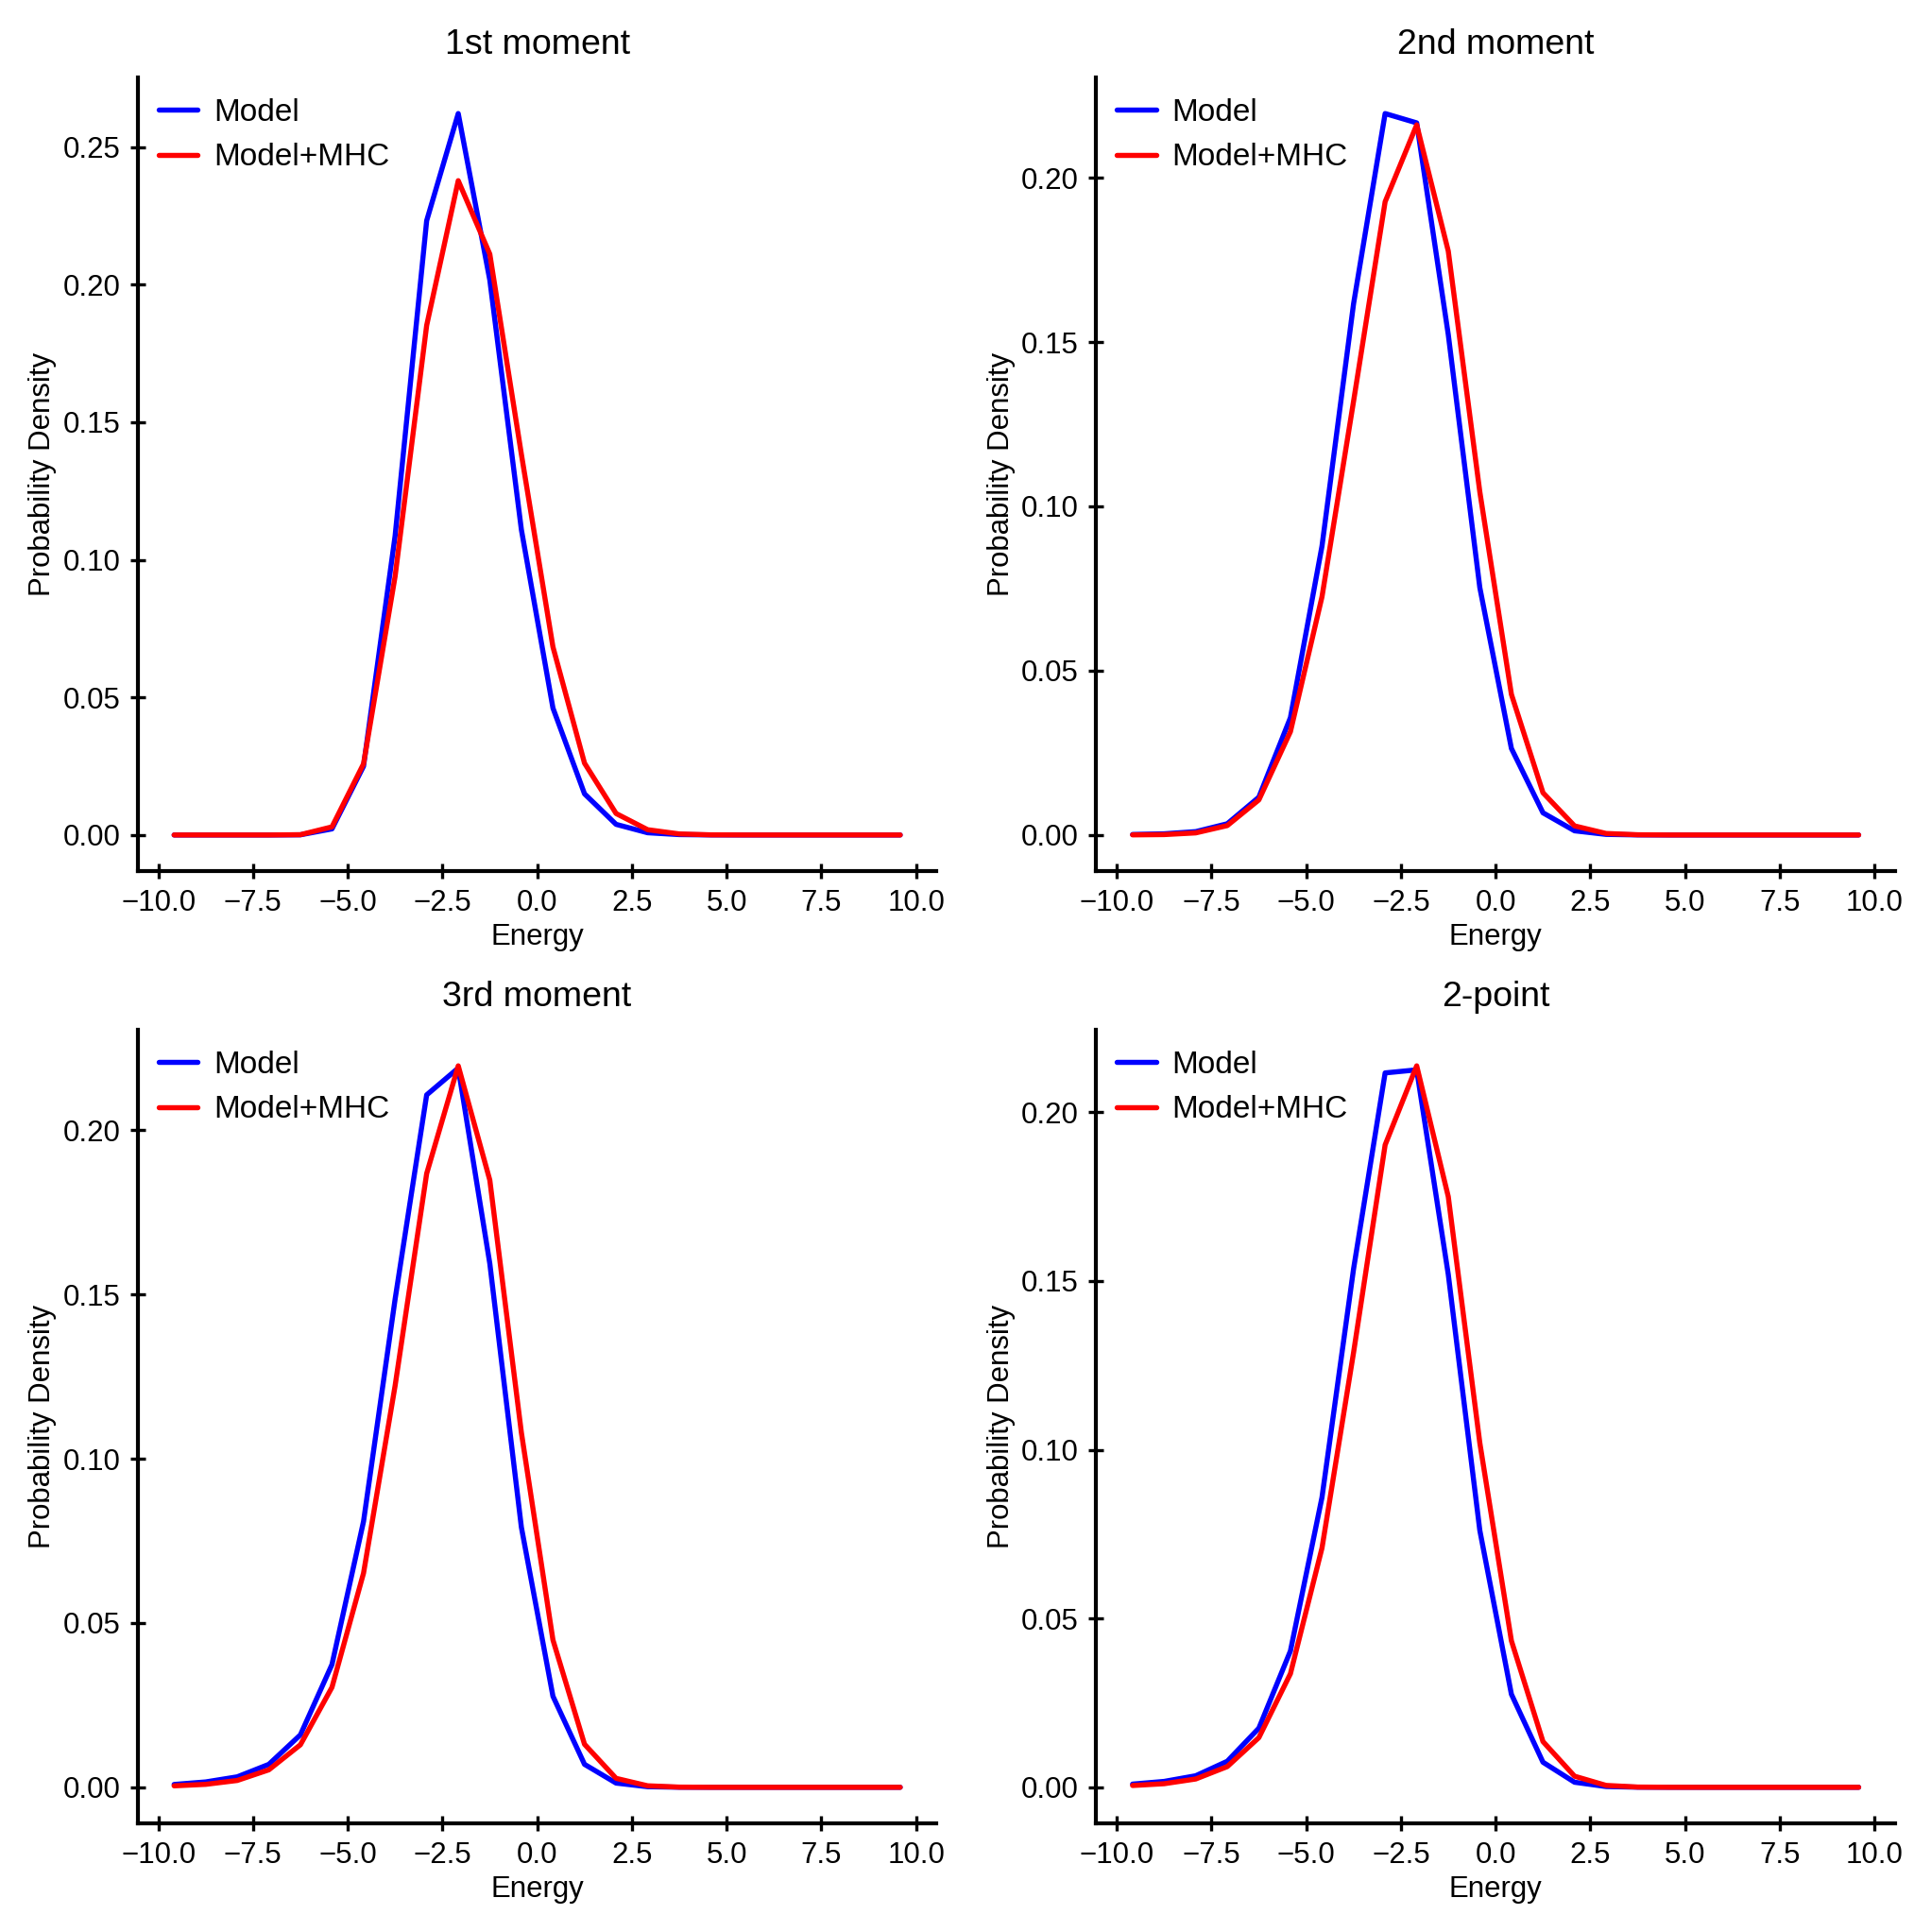

In [42]:
plt.figure(figsize=(8,8))
# fig, axs = plt.subplots(2,2)

model_mappper = {
    "independent": "1st moment",
    "ncov": "2nd moment",
    "nskew": "3rd moment",
    "nskewfcov": "2-point"
}

all_sample =  data[f"Human_{n}_{t}"]
mhc_sample = data[f"MHC_top_Human_{n}_{t}"]

for i,model in enumerate(models):

    bins = np.linspace(-10, 10, 25)
    
    plt.subplot(2,2,i+1)
    count, bins_count = np.histogram(all_sample['energies'][model],bins=bins)
    pdf = count / sum(count)
    plt.plot(0.5*(bins[:-1]+bins[1:]), pdf, 'b',label='Model')
    
    count, bins_count = np.histogram(mhc_sample['energies'][model],bins=bins)

    pdf = count / sum(count)
    plt.plot(0.5*(bins[:-1]+bins[1:]), pdf, 'r', label='Model+MHC')
    plt.xlabel('Energy')
    plt.title(model_mappper[model])
    plt.ylabel('Probability Density')
    plt.legend(loc='upper left',fontsize=8)
plt.savefig('plots/human_models_and_mhc_energies.png')

## same analysis but for virus model

In [7]:
virus_model_s_dict = defaultdict(list)
virus_model_pc_dict = defaultdict(list)
virus_model_s_mhc_dict = defaultdict(list)
virus_model_pc_mhc_dict = defaultdict(list)
virus_model_pct_binder_dict = defaultdict(list)

models = ['independent', 'ncov', 'nskew', 'nskewfcov']
n="1e7"
thin="60"

proteome = "Humanviruses"

for model in models:
    
    path_base = f"data/mhc_sampling_results/{proteome}_{model}_{n}_{thin}_"
    for idx,haplotype in haplotypes.iterrows():
        hap_str = "|".join(list(haplotype))
        with open(f"{path_base}{hap_str}.json","r") as f:
            result = json.load(f)
        
        virus_model_s_dict[model].append(result['S'])
        virus_model_s_mhc_dict[model].append(result['S_mhc_with_logb'])
        virus_model_pc_dict[model].append(result['pc'])
        virus_model_pc_mhc_dict[model].append(result['pc_mhc'])
        virus_model_pct_binder_dict[model].append(result['b'])

In [8]:
result

{'proteome': 'Humanviruses',
 'model': 'nskewfcov_1e7_60',
 'haplotype': 'HLA-A0201,HLA-A0201,HLA-B0801,HLA-B1501,HLA-C0602,HLA-C0702',
 'N': 10000000,
 'pc': 5.782600578260058e-10,
 'S': 25.83890172918632,
 'N_mhc': 438044,
 'b': 0.0438044,
 'pc_mhc': 2.324343863530148e-09,
 'S_mhc_raw': 26.19732337058671,
 'S_mhc_with_logb': 23.06930236056255}

/scratch/lsftmp/9803482.tmpdir/ipykernel_55905/3461123644.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(loc='best')


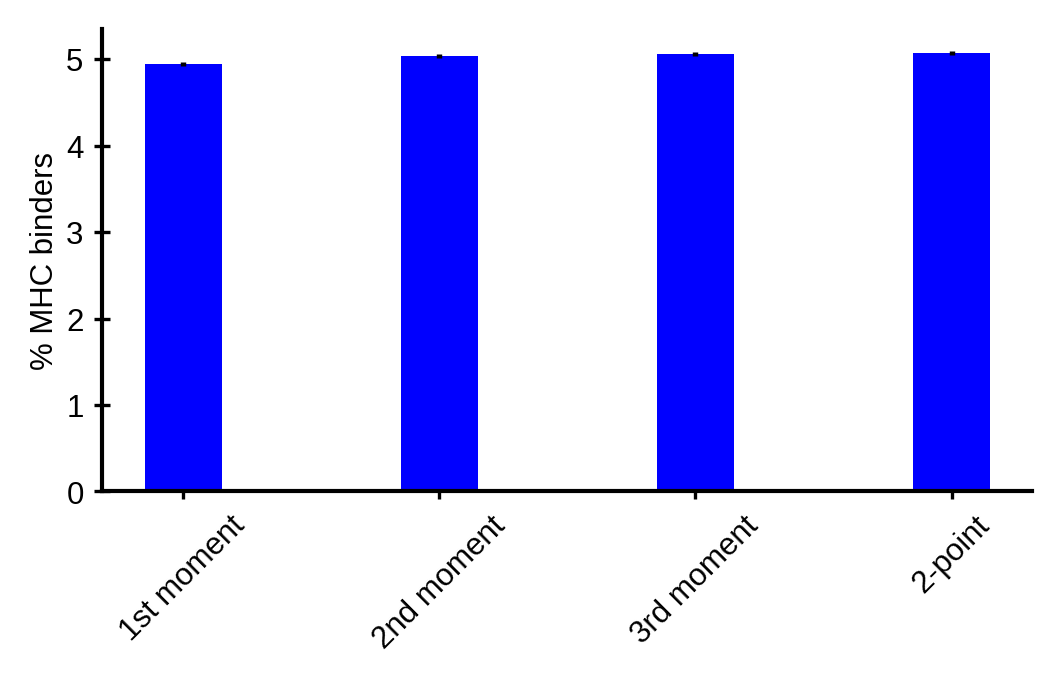

In [9]:
# percent binder plot

fig, ax1 = plt.subplots(figsize=(4, 2))

models = ['independent', 'ncov', 'nskew', 'nskewfcov']
mean_values = [100*np.mean(np.array(virus_model_pct_binder_dict[model])) for model in models]
ste_values = [100*sem(np.array(virus_model_pct_binder_dict[model])) for model in models]

labels = ['1st moment', '2nd moment', '3rd moment', '2-point']

ind = np.arange(len(models))
width = 0.3       
ax1.bar(ind, mean_values,width,yerr=ste_values,color='blue')
ax1.set_ylabel('% MHC binders')
ax1.set_xticks(ind, labels,rotation=45)
ax1.legend(loc='best')
plt.savefig('plots/virus_percent_mhc_haplotypes.png')

In [23]:
def get_mhc_df(model, proteome, allele):
    try:
        if proteome == 'Human':
            return pd.read_csv(f"data/netMHC_output/net_mhc_output_{model}-{allele}.csv")
        else:
            return pd.read_csv(f"data/netMHC_output/net_mhc_output_{proteome}_{model}-{allele}.csv")
    except Exception as e:
        print("PD ERROR")
        print(model)
        print(allele)
        return None

        
def get_combined_binders(model, proteome, alleles):
    kmers = set()
    for allele in alleles:
        mhc_df = get_mhc_df(model, proteome, allele)
        if mhc_df is not None:
            new_set = set(mhc_df["Peptide"])
            kmers = kmers.union(new_set)
    return kmers

In [26]:
proteome = 'Humanviruses'
models = ['nskewfcov']

n="1e7"
t="60"

top_haplotype_data_virus = {
    model: dict() for model in models
}

for model in models:
    print(f'model: {model}')
    energy = make_energy(np.load(f'data/{proteome}_{model}_k{k}_params.npz'))
    F = float(pd.read_csv(f"data/mcmc_thermo/{proteome}_{model}_{n}_{t}_entropy.csv",header=None, index_col=0).loc['F'].values[0])
    
    loglikelihood  = lambda seq: -energy(seq) + F
    
    matrix = load_matrix(f"data/mcmc_thermo/{proteome}_{model}_{n}_{t}_matrix.csv.gz")

    

    binders = get_combined_binders(f"{model}_{n}_{t}", proteome, list(top_hap))
    kmers = matrix_to_kmers(matrix)
    kmers_mhc = [km for km in kmers if km in binders]
    matrix_mhc = kmers_to_matrix(kmers_mhc)
    
    top_haplotype_data_virus[model]['b'] = matrix_mhc.shape[0]/matrix.shape[0]
    top_haplotype_data_virus[model]['pc'] = compute_pc(matrix)
    top_haplotype_data_virus[model]['pc_mhc'] = compute_pc(matrix_mhc)

    energies = [energy(x) for x in matrix]
    top_haplotype_data_virus[model]['energies'] = energies
    top_haplotype_data_virus[model]['S'] = np.mean(np.array(energies)) - F 
   

    energies_mhc = [energy(x) for x in matrix_mhc]
    top_haplotype_data_virus[model]['energies_mhc'] = energies_mhc
    top_haplotype_data_virus[model]['S_mhc'] = np.mean(np.array(energies)) - F + np.log(top_haplotype_data_virus[model]['b'])

model: nskewfcov


In [21]:
proteome = 'Human'
models = ['nskewfcov']

n="1e7"
t="60"

top_haplotype_data_human = {
    model: dict() for model in models
}

for model in models:
    print(f'model: {model}')
    energy = make_energy(np.load(f'data/{proteome}_{model}_k{k}_params.npz'))
    F = float(pd.read_csv(f"data/mcmc_thermo/{proteome}_{model}_{n}_{t}_entropy.csv",header=None, index_col=0).loc['F'].values[0])
    
    loglikelihood  = lambda seq: -energy(seq) + F
    
    matrix = load_matrix(f"data/mcmc_thermo/{proteome}_{model}_{n}_{t}_matrix.csv.gz")

    

    binders = get_combined_binders(model, proteome, list(top_hap))
    kmers = matrix_to_kmers(matrix)
    kmers_mhc = [km for km in kmers if km in binders]
    matrix_mhc = kmers_to_matrix(kmers_mhc)
    
    top_haplotype_data_human[model]['b'] = matrix_mhc.shape[0]/matrix.shape[0]
    top_haplotype_data_human[model]['pc'] = compute_pc(matrix)
    top_haplotype_data_human[model]['pc_mhc'] = compute_pc(matrix_mhc)

    energies = [energy(x) for x in matrix]
    top_haplotype_data_human[model]['energies'] = energies
    top_haplotype_data_human[model]['S'] = np.mean(np.array(energies)) - F 
   

    energies_mhc = [energy(x) for x in matrix_mhc]
    top_haplotype_data_human[model]['energies_mhc'] = energies_mhc
    top_haplotype_data_human[model]['S_mhc'] = np.mean(np.array(energies)) - F + np.log(top_haplotype_data_human[model]['b'])
    

model: nskewfcov
HLA-A0101
HLA-A0201
HLA-B0702
HLA-B0801
HLA-C0701
HLA-C0702


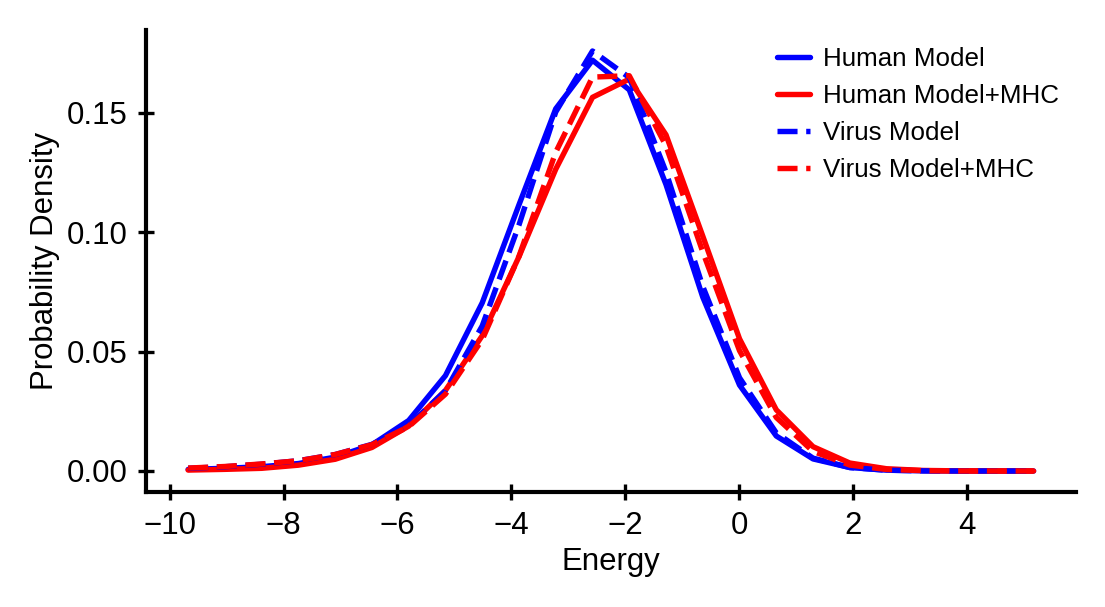

In [27]:


model = "nskewfcov"

fig, ax1 = plt.subplots(figsize=(4,2))
bins = np.linspace(-10, 5.5, 25)

count, bins_count = np.histogram(top_haplotype_data_human[model]['energies'],bins=bins)
pdf = count / sum(count)
plt.plot(0.5*(bins[:-1]+bins[1:]), pdf, 'b',label='Human Model')

count, bins_count = np.histogram(top_haplotype_data_human[model]['energies_mhc'],bins=bins)
pdf = count / sum(count)
plt.plot(0.5*(bins[:-1]+bins[1:]), pdf, 'r', label='Human Model+MHC')


count, bins_count = np.histogram(top_haplotype_data_virus[model]['energies'],bins=bins)
pdf = count / sum(count)
plt.plot(0.5*(bins[:-1]+bins[1:]), pdf, 'b--',label='Virus Model')

count, bins_count = np.histogram(top_haplotype_data_virus[model]['energies_mhc'],bins=bins)
pdf = count / sum(count)
plt.plot(0.5*(bins[:-1]+bins[1:]), pdf, 'r--', label='Virus Model+MHC')

plt.xlabel('Energy')
plt.ylabel('Probability Density')
plt.legend(loc='upper right')

plt.savefig('plots/top_hap_energies.png')

<>:46: SyntaxWarning: invalid escape sequence '\e'
<>:46: SyntaxWarning: invalid escape sequence '\e'
/scratch/lsftmp/9056930.tmpdir/ipykernel_26489/2521821770.py:46: SyntaxWarning: invalid escape sequence '\e'
  ax1.set_ylabel('$\exp(S)/20^k$')


-0.05
-0.06
-0.11


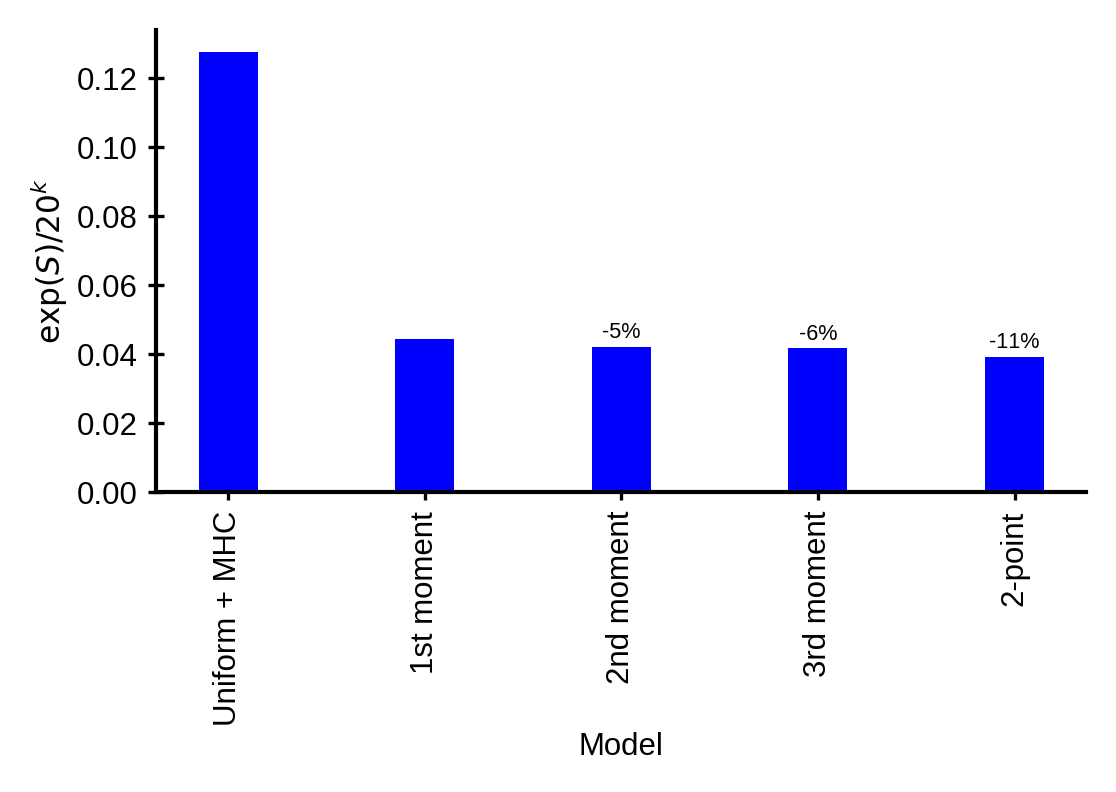

In [37]:
# MHC applied to uniform peptides
# entropy
k=9
uniform_entropy = np.exp(k*np.log(20))

n = "1e7"
t = "9"


models = ['independent', 'ncov', 'nskew', 'nskewfcov']
N = len(models)

entropies_mhc = np.exp([data[f"MHC_top_Human_{n}_{t}"]["S"][model]+
                        np.log(data[f"MHC_top_Human_{n}_{t}"]["pct_binders"][model]) for model in models])

uniform_mhc = np.exp(data["uniform"]["S"])
# entropies_all = np.exp(entropies_all)


fig, ax1 = plt.subplots(figsize=(4, 2))

labels = ['Uniform + MHC', '1st moment', '2nd moment', '3rd moment', '2-point']
width = .3
x = np.arange(len(labels))
# rects1 = ax1.bar(x[:-1], entropies_models/uniform_entropy, width, color='blue',label='Model')
rects2 = ax1.bar(x[1:], entropies_mhc/uniform_entropy, width, color='blue', label='Model +MHC')
rects3 = ax1.bar(x[:1], uniform_mhc/uniform_entropy, width, color='blue')
# rects2 = ax1.bar(x[-1:], uniform_entropy/uniform_entropy, width, color='black')

ax1.set_xticks(x)
ax1.set_xticklabels(labels, rotation=90)
# ax1.axhline(data[1]/data[0], ls='--')

reduction = ((entropies_mhc[1:]-entropies_mhc[0])/entropies_mhc[0])
for rect, toplabel in zip(rects2[1:], reduction):
    print('{0:.2f}'.format(toplabel))
    ax1.annotate('{0:.0f}%'.format(100*toplabel),
                xy=(rect.get_x()+width/2, rect.get_height()),
                xytext=(0, 1),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize='xx-small')

    
ax1.set_xlabel('Model')

ax1.set_ylabel('$\exp(S)/20^k$')

plt.savefig('plots/shannon_mhc_models.png')

In [29]:
entropies_mhc/uniform_entropy

array([0.04421417, 0.04189202, 0.04157317, 0.03918496])

In [20]:
reduction = ((entropies_mhc[1:]-entropies_mhc[0])/entropies_mhc[0])
for rect, toplabel in zip(rects2[1:], reduction):
    print('{0:.2f}'.format(toplabel))
#     ax1.annotate('{0:.0f}%'.format(100*toplabel),
#                 xy=(rect.get_x()+width/2, rect.get_height()),
#                 xytext=(0, 1),  # 3 points vertical offset
#                 textcoords="offset points",
#                 ha='center', va='bottom', fontsize='xx-small') 
    

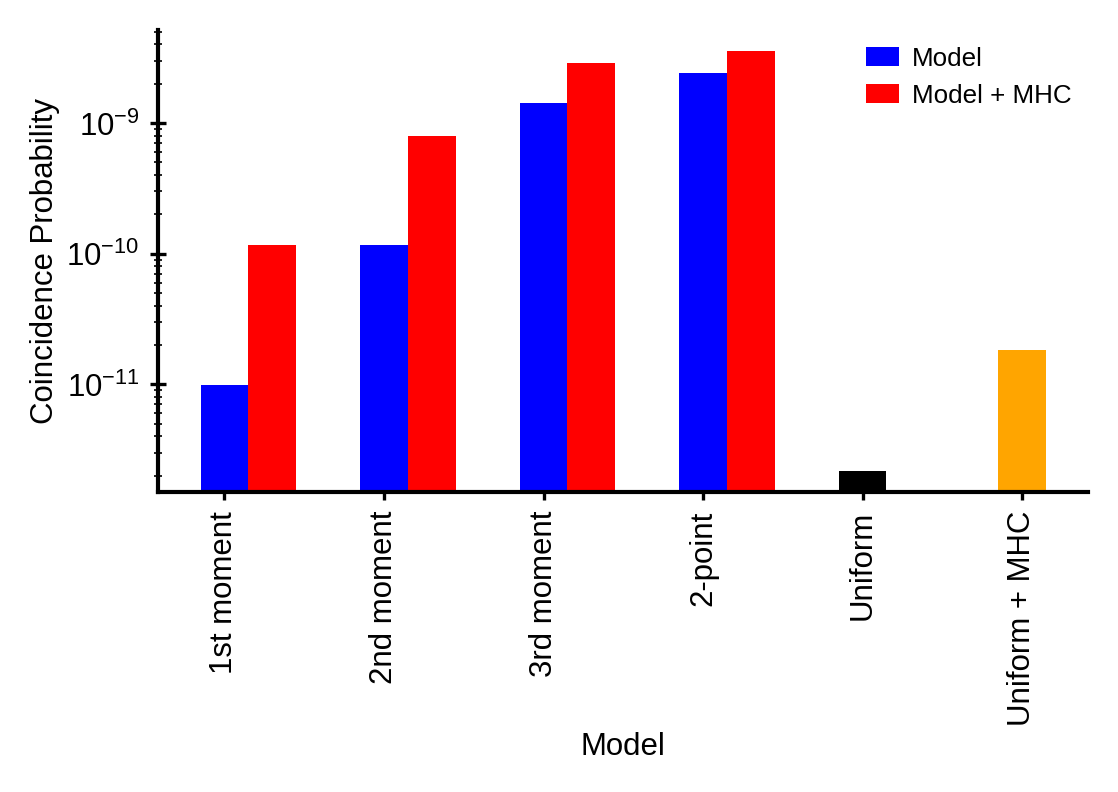

<Figure size 3000x1500 with 0 Axes>

In [41]:
# pc
n = "1e7"
t = "9"

fig, ax1 = plt.subplots(figsize=(4, 2))


models = ['independent', 'ncov', 'nskew', 'nskewfcov']
labels = ['1st moment', '2nd moment', '3rd moment', '2-point', 'Uniform', 'Uniform + MHC']


mhc_sample = data[f"MHC_top_Human_{n}_{t}"]
data_mhc = [(mhc_sample["pc"][model]) for model in models]

all_sample =  data[f"Human_{n}_{t}"]
data_all = [all_sample["pc"][model] for model in models]

data_uniform = data["uniform"]["pc"]
data_uniform_mhc = data["uniform"]["pc_mhc"]


ind = np.arange(len(labels))
plt.figure(figsize=(10,5))
width = 0.3       


ax1.bar(ind[:-2], data_all,width, label='Model',color='blue')
ax1.bar(ind[:-2] + width, data_mhc, width, label='Model + MHC',color='red')
ax1.bar(ind[-2:-1],data_uniform, width,color='black')
ax1.bar(ind[-1:],data_uniform_mhc, width, color='orange')

ax1.set_yscale('log')
ax1.set_xlabel('Model')
ax1.set_ylabel('Coincidence Probability')
ax1.set_xticks(ind)
ax1.set_xticklabels(labels, rotation=90)
ax1.legend()

plt.savefig('plots/coincidence_human_mhc_models.png')

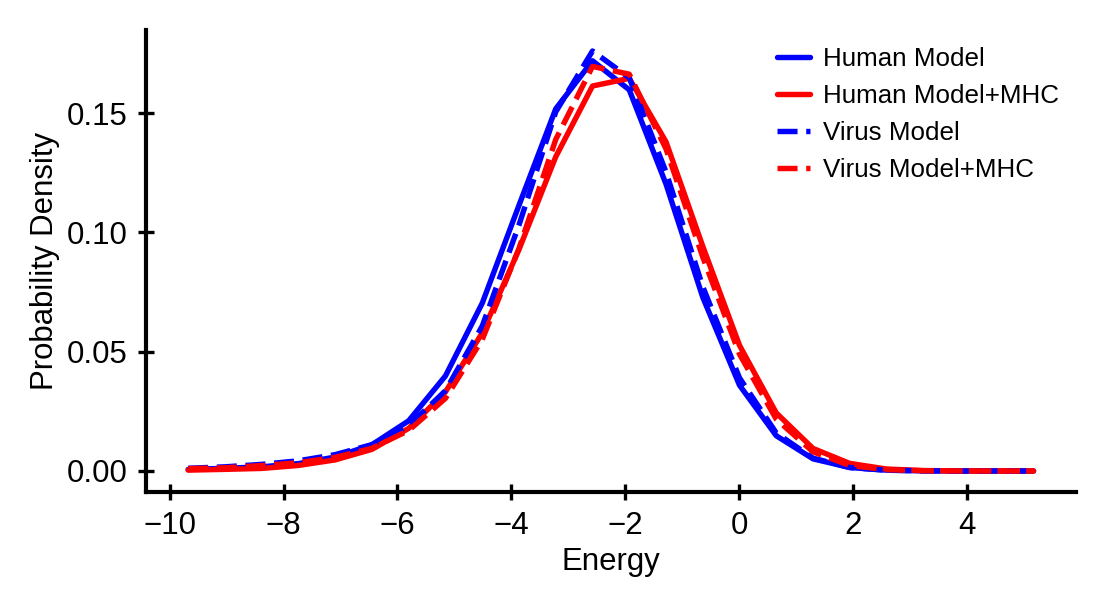

In [36]:
human_sampler = data["Human_1e7_9"]
human_mhc_sampler = data["MHC_top_Human_1e7_9"]

virus_sampler = virus_data["Humanviruses_1e7_9"]
virus_mhc_sampler = virus_data["MHC_top_Humanviruses_1e7_9"]

model = "nskewfcov"

fig, ax1 = plt.subplots(figsize=(4,2))
bins = np.linspace(-10, 5.5, 25)

count, bins_count = np.histogram(human_sampler['energies'][model],bins=bins)
pdf = count / sum(count)
plt.plot(0.5*(bins[:-1]+bins[1:]), pdf, 'b',label='Human Model')

count, bins_count = np.histogram(human_mhc_sampler['energies'][model],bins=bins)
pdf = count / sum(count)
plt.plot(0.5*(bins[:-1]+bins[1:]), pdf, 'r', label='Human Model+MHC')


count, bins_count = np.histogram(virus_sampler['energies'][model],bins=bins)
pdf = count / sum(count)
plt.plot(0.5*(bins[:-1]+bins[1:]), pdf, 'b--',label='Virus Model')

count, bins_count = np.histogram(virus_mhc_sampler['energies'][model],bins=bins)
pdf = count / sum(count)
plt.plot(0.5*(bins[:-1]+bins[1:]), pdf, 'r--', label='Virus Model+MHC')

plt.xlabel('Energy')
plt.ylabel('Probability Density')
plt.legend(loc='upper right')



In [ ]:
human_sampler = data["Human_1e7_9"]
human_mhc_sampler = data["MHC_top_Human_1e7_9"]


model = "nskewfcov"

fig, ax1 = plt.subplots(figsize=(4,2))
bins = np.linspace(-10, 5.5, 25)

count, bins_count = np.histogram(human_sampler['energies'][model],bins=bins)
pdf = count / sum(count)
plt.plot(0.5*(bins[:-1]+bins[1:]), pdf, 'b',label='Human Model')

count, bins_count = np.histogram(human_mhc_sampler['energies'][model],bins=bins)
pdf = count / sum(count)
plt.plot(0.5*(bins[:-1]+bins[1:]), pdf, 'r', label='Human Model+MHC')


count, bins_count = np.histogram(virus_sampler['energies'][model],bins=bins)
pdf = count / sum(count)
plt.plot(0.5*(bins[:-1]+bins[1:]), pdf, 'b--',label='Virus Model')

count, bins_count = np.histogram(virus_mhc_sampler['energies'][model],bins=bins)
pdf = count / sum(count)
plt.plot(0.5*(bins[:-1]+bins[1:]), pdf, 'r--', label='Virus Model+MHC')

plt.xlabel('Energy')
plt.ylabel('Probability Density')
plt.legend(loc='upper right')



# Other random analyses

In [ ]:
def plot_pairwise_aa_freq_counter(kmers1, kmers2, name1, name2, title=None, annotate=False):
    counts1 = Counter("".join(kmers1))
    counts2 = Counter("".join(kmers2))
    plt.figure()

    denominator1 = len(kmers1)*len(kmers1[0])
    denominator2 = len(kmers2)*len(kmers2[0])

    f1 = [counts1[letter]/denominator1 for letter in counts1]
    f2 = [counts2[letter]/denominator2 for letter in counts1]
    max1 = max(f1)
    max2 = max(f2)
    maxmax = max(max1,max2)

    plt.scatter(f1,f2)
    plt.plot([0,maxmax],[0,maxmax], 'k--')
    plt.xlabel(f'AA freq: {name1}')
    plt.ylabel(f'AA freq: {name2}')
    if title:
        plt.title(title)


    if annotate:
        letters = [l for l in counts1]
        
        for i, txt in enumerate(letters):
            plt.annotate(txt, (f1[i], f2[i]))
    plt.show()
# def plot_pairwise_aa_freq_manual(kmers1, kmers2, name1, name2, title=None):
#     counts1 = defaultdict(int)
#     counts2 = defaultdict(int)

#     for kmer in kmers1:
#         for k in kmer:
#             counts1[k] += 1
#     for kmer in kmers2:
#         for k in kmer:
#             counts2[k] += 1
    
#     plt.figure()

#     f1 = [counts1[letter]/len(kmers1) for letter in counts1]
#     f2 = [counts2[letter]/len(kmers2) for letter in counts1]
#     max1 = max(f1)
#     max2 = max(f2)
#     maxmax = max(max1,max2)

#     plt.scatter(f1,f2)
#     plt.plot([0,maxmax],[0,maxmax], 'k--')
#     plt.xlabel(f'AA freq: {name1}')
#     plt.ylabel(f'AA freq: {name2}')
#     if title:
#         plt.title(title)
#     plt.show()

In [108]:
model = 'ncov'
matrix_human = matrix_to_kmers(load_matrix(f'data/Human_{model}_k{k}_matrix.csv.gz'))
matrix_virus = matrix_to_kmers(load_matrix(f'data/Humanviruses_{model}_k{k}_matrix.csv.gz'))
matrix_malaria = matrix_to_kmers(load_matrix(f'data/Malaria_{model}_k{k}_matrix.csv.gz'))

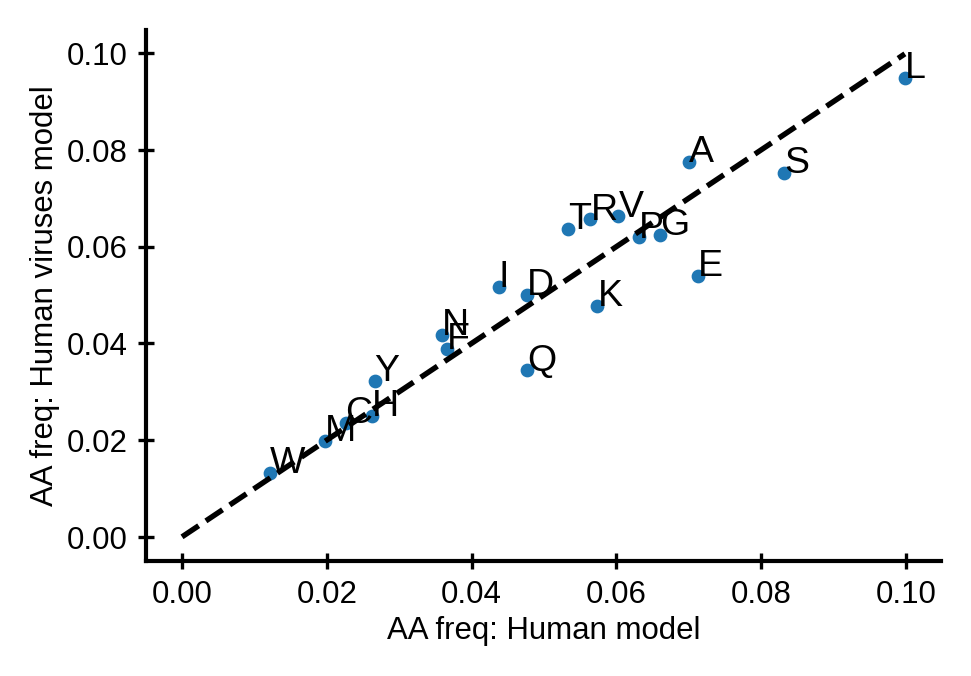

In [124]:
plot_pairwise_aa_freq_counter(matrix_human,matrix_virus, 'Human model', 'Human viruses model', annotate=True)

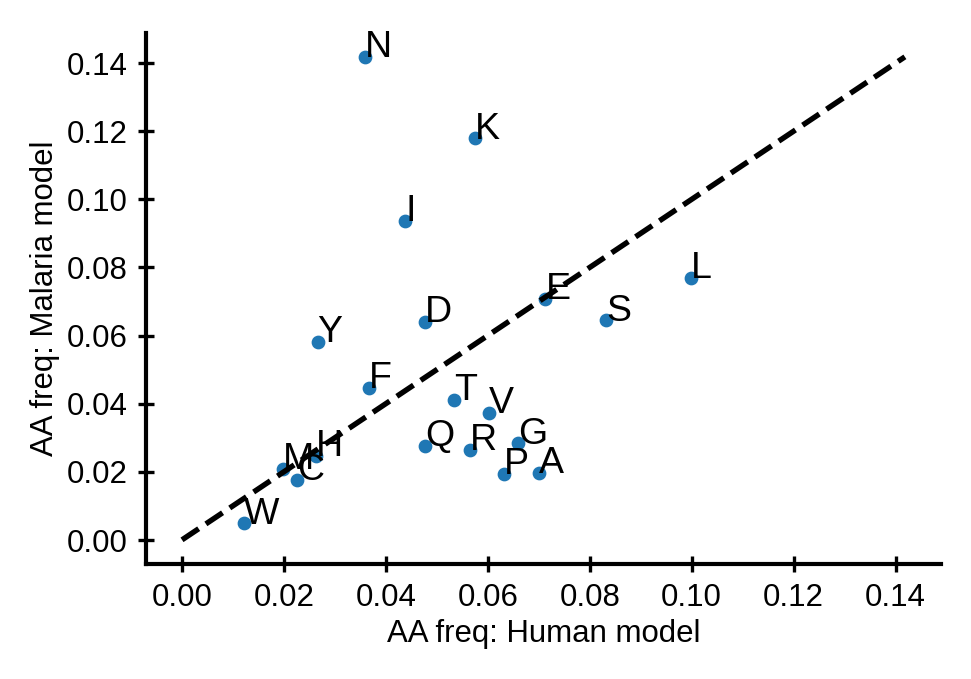

In [125]:
plot_pairwise_aa_freq_counter(matrix_human,matrix_malaria,'Human model', 'Malaria model', annotate=True)


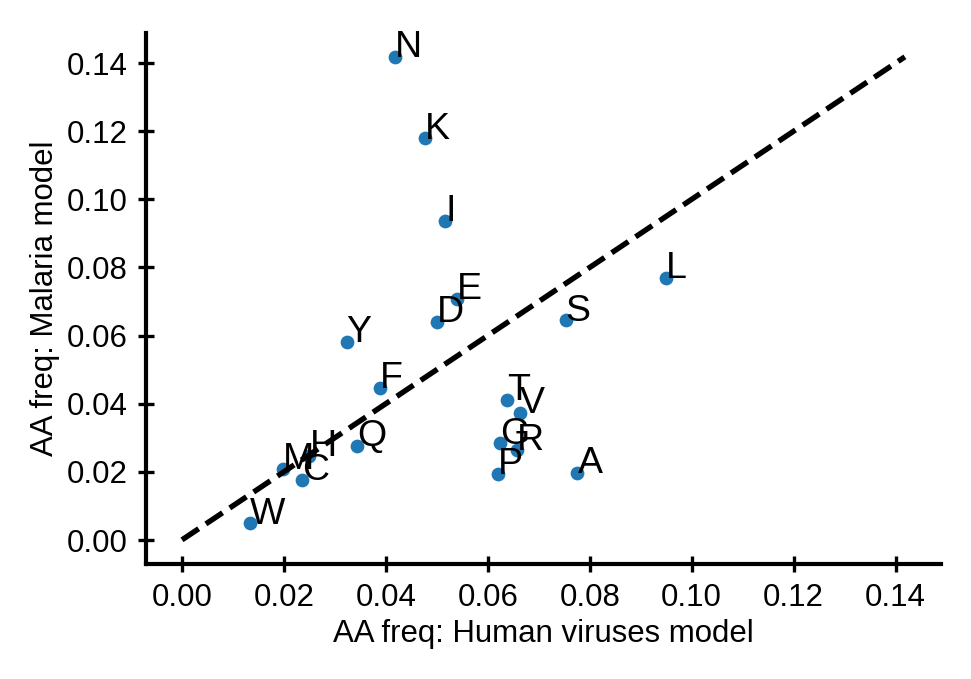

In [126]:
plot_pairwise_aa_freq_counter(matrix_virus,matrix_malaria,'Human viruses model', 'Malaria model', annotate=True)

## MHC and Classification

In [98]:
# test data sets restricted by MHC
matrix_human_test = load_matrix('../maxent/data/Human_test_k9_matrix.csv.gz')
kmers = matrix_to_kmers(matrix_human_test)
with open("data/netMHC_input/net_mhc_input_Human_test.txt",'w') as f:
    for item in kmers:
        f.write(f"{item}\n")

In [99]:
matrix_humanviruses_test = load_matrix('../maxent/data/Humanviruses_test_k9_matrix.csv.gz')
kmers = matrix_to_kmers(matrix_humanviruses_test)
with open("data/netMHC_input/net_mhc_input_Humanviruses_test.txt",'w') as f:
    for item in kmers:
        f.write(f"{item}\n")

In [100]:
def get_mhc_df(model, allele):
    try:
        return pd.read_csv(f'data/netMHC_output/net_mhc_output_{model}-{allele}.csv')
    except Exception as e:
        print(f'Missing CSV: {model},{allele}')
        return None
        
def get_combined_binders(model, alleles):

    kmers = set()
    for allele in alleles:
        print(allele)
        mhc_df = get_mhc_df(model, allele)
        if mhc_df is not None:
            try:
                kmers = kmers.union(set(mhc_df['Peptide']))
            except Exception as e:
                print(f'Messed up CSV: {model},{allele}')
                print(e)
    return kmers

In [102]:
human_matrix = load_matrix('data/Human_test_k9_matrix.csv.gz')
human_binders = get_combined_binders('Human_test', list(top_hap))

human_kmers = matrix_to_kmers(human_matrix)
human_kmers_mhc = [km for km in human_kmers if km in human_binders]
human_matrix_mhc = kmers_to_matrix(human_kmers_mhc)

    
virus_matrix = load_matrix('data/Humanviruses_test_k9_matrix.csv.gz')
virus_binders = get_combined_binders('Humanviruses_test', list(top_hap))
virus_kmers = matrix_to_kmers(virus_matrix)
virus_kmers_mhc = [km for km in virus_kmers if km in virus_binders]
virus_matrix_mhc = kmers_to_matrix(virus_kmers_mhc)

HLA-A0101
HLA-A0201
HLA-B0702
HLA-B0801
HLA-C0701
HLA-C0702
HLA-A0101
HLA-A0201
HLA-B0702
HLA-B0801
HLA-C0701
HLA-C0702


In [103]:
logp_dict = {}
models = ['independent', 'ncov', 'nskew', 'nskewfcov']
# models = ['ncov']


for model in models:
    
    
    
    # human values with and without MHC
    energy_human = make_energy(np.load(f'data/Human_{model}_k9_params.npz'))
    F_human = float(pd.read_csv(f"data/Human_{model}_k9_entropy.csv",header=None, index_col=0).loc['F'].values[0])
    loglikelihood_human  = lambda seq: -energy_human(seq) + F_human
    
    
    # virus values with and without MHC
    energy_virus = make_energy(np.load(f'data/Humanviruses_{model}_k9_params.npz'))
    F_virus = float(pd.read_csv(f'data/Humanviruses_{model}_k9_entropy.csv',header=None, index_col=0).loc['F'].values[0])
    loglikelihood_virus  = lambda seq: -energy_virus(seq) + F_virus
    

    logp_hh = np.array([loglikelihood_human(kmer) for kmer in human_matrix])
    logp_hv = np.array([loglikelihood_virus(kmer) for kmer in human_matrix])
    logp_vv = np.array([loglikelihood_virus(kmer) for kmer in virus_matrix])
    logp_vh = np.array([loglikelihood_human(kmer) for kmer in virus_matrix])
    
    logp_hh_mhc = np.array([loglikelihood_human(kmer) for kmer in human_matrix_mhc])
    logp_hv_mhc = np.array([loglikelihood_virus(kmer) for kmer in human_matrix_mhc])
    logp_vv_mhc = np.array([loglikelihood_virus(kmer) for kmer in virus_matrix_mhc])
    logp_vh_mhc = np.array([loglikelihood_human(kmer) for kmer in virus_matrix_mhc])
    
    logp_dict[model] = {
        
        'hh': logp_hh,
        'hv': logp_hv,
        'vv': logp_vv,
        'vh': logp_vh,
        
        'hh_mhc': logp_hh_mhc,
        'hv_mhc': logp_hv_mhc,
        'vv_mhc': logp_vv_mhc,
        'vh_mhc': logp_vh_mhc
    }


In [7]:
from sklearn.metrics import average_precision_score, precision_recall_curve, auc, roc_curve

In [105]:
results = {}

for i, model in enumerate(models):
    
    logp_hh = logp_dict[model]['hh']
    logp_hv = logp_dict[model]['hv']
    logp_vv = logp_dict[model]['vv']
    logp_vh = logp_dict[model]['vh']
    
    logp_hh_mhc = logp_dict[model]['hh_mhc']
    logp_hv_mhc = logp_dict[model]['hv_mhc']
    logp_vv_mhc = logp_dict[model]['vv_mhc']
    logp_vh_mhc = logp_dict[model]['vh_mhc']
    
    class_data = {}

    # normal data - classifying virus=1; human=0
    positive = logp_vv-logp_vh #likelihood ratio for virus kmers
    negative = logp_hv-logp_hh #likelihood ratio for human kmers

    y_true = np.concatenate([np.ones(len(positive)), np.zeros(len(negative))])
    y_score = np.concatenate([positive, negative])
    fpr, tpr, thresholds_roc = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    class_data['fpr'], class_data['tpr'], class_data['roc_auc'] = fpr, tpr, roc_auc
    precision, recall, thresholds_pr = precision_recall_curve(y_true, y_score)
    average_precision = average_precision_score(y_true, y_score)

    class_data['precision'], class_data['recall'], class_data['average_precision'] = precision, recall, average_precision

    
    class_data['negative_excess'] = len(logp_hh)/len(logp_vv)
    
    # mhc restricted data
    positive_mhc = logp_vv_mhc-logp_vh_mhc #likelihood ratio for virus kmers
    negative_mhc = logp_hv_mhc-logp_hh_mhc #likelihood ratio for human kmers
    y_true_mhc = np.concatenate([np.ones(len(positive_mhc)), np.zeros(len(negative_mhc))])
    y_score_mhc = np.concatenate([positive_mhc, negative_mhc])
    fpr_mhc, tpr_mhc, thresholds_roc_mhc = roc_curve(y_true_mhc, y_score_mhc)
    roc_auc_mhc = auc(fpr_mhc, tpr_mhc)

    class_data['fpr_mhc'], class_data['tpr_mhc'], class_data['roc_auc_mhc'] = fpr_mhc, tpr_mhc, roc_auc_mhc
    precision_mhc, recall_mhc, thresholds_pr_mhc = precision_recall_curve(y_true_mhc, y_score_mhc)
    average_precision_mhc = average_precision_score(y_true_mhc, y_score_mhc)

    class_data['precision_mhc'], class_data['recall_mhc'], class_data['average_precision_mhc'] = precision_mhc, recall_mhc, average_precision_mhc
    class_data['negative_excess_mhc'] = len(logp_hh_mhc)/len(logp_vv_mhc)
    
    results[model] = class_data

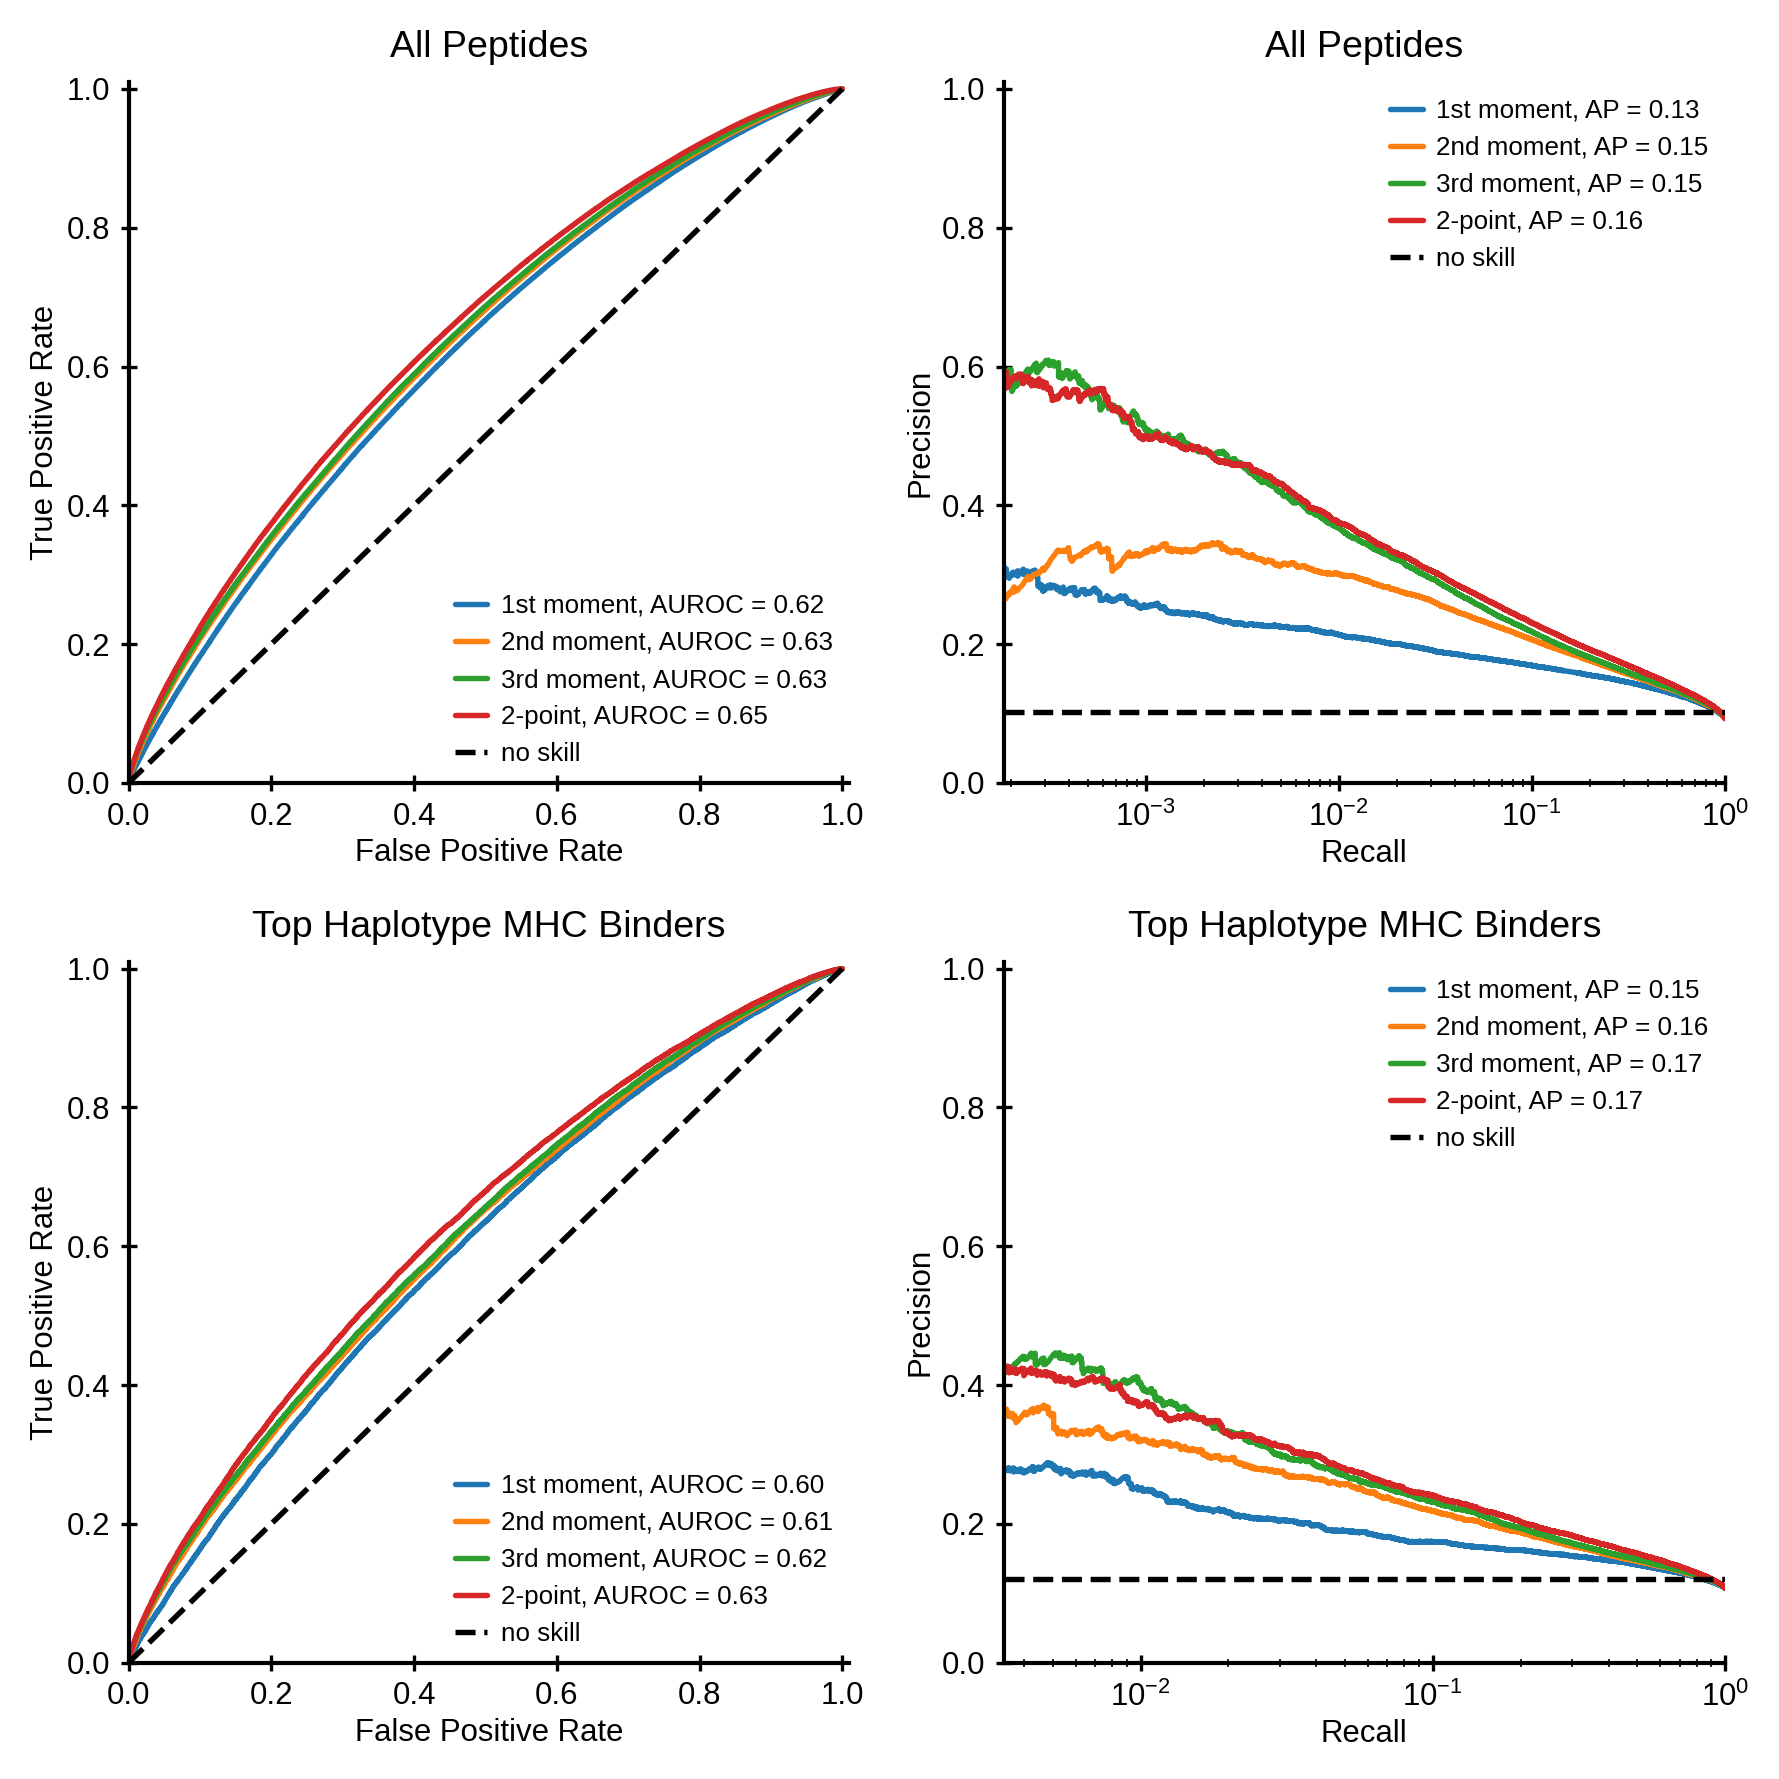

In [111]:
fig, axes = plt.subplots(figsize=(6, 6), ncols=2, nrows=2)


ax = axes[0,0]
for model, class_data in results.items():
    ax.plot(class_data['fpr'], class_data['tpr'],
            label=f'{model_mapper[model]}, AUROC = %0.2f' % class_data['roc_auc'])
    
ax.plot([0, 1], [0, 1], color='k', linestyle='--', label='no skill')
ax.set_xlim(0.0, 1.01)
ax.set_ylim(0.0, 1.01)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
# ax.legend(loc="lower left", bbox_to_anchor=(0.0, 1.0))
ax.legend(loc='lower right')

ax.set_title('All Peptides')


ax = axes[1,0]
for model, class_data in results.items():
    ax.plot(class_data['fpr_mhc'], class_data['tpr_mhc'],
            label=f'{model_mapper[model]}, AUROC = %0.2f' % class_data['roc_auc_mhc'])
    
ax.plot([0, 1], [0, 1], color='k', linestyle='--', label='no skill')
ax.set_xlim(0.0, 1.01)
ax.set_ylim(0.0, 1.01)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
# ax.legend(loc="lower left", bbox_to_anchor=(0.0, 1.0))
ax.legend(loc='lower right')


ax.set_title('Top Haplotype MHC Binders')




ax = axes[0,1]
for model, class_data in results.items():
    ax.plot(class_data['recall'], class_data['precision'],
            label=f'{model_mapper[model]}, AP = %0.2f' % class_data['average_precision'])
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.axhline(1.0/class_data['negative_excess'], c='k', ls='--', label='no skill')
ax.set_ylim(0.0, 1.01)
#ax.set_xlim(0.0, 1.01)
ax.set_xscale('log')
ax.set_xticks(10.0**np.arange(-4, 1, 1))
ax.set_xlim(100/len(logp_vv), 1.0)
# ax.legend(loc='lower left', bbox_to_anchor=(0.0, 1.0))
ax.legend(loc='upper right')

ax.set_title('All Peptides')


ax = axes[1,1]
for model, class_data in results.items():
    ax.plot(class_data['recall_mhc'], class_data['precision_mhc'],
            label=f'{model_mapper[model]}, AP = %0.2f' % class_data['average_precision_mhc'])
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.axhline(1.0/class_data['negative_excess_mhc'], c='k', ls='--', label='no skill')
ax.set_ylim(0.0, 1.01)
#ax.set_xlim(0.0, 1.01)
ax.set_xscale('log')
ax.set_xticks(10.0**np.arange(-4, 1, 1))
ax.set_xlim(100/len(logp_vv_mhc), 1.0)
ax.legend(loc='upper right')
ax.set_title('Top Haplotype MHC Binders')

fig.tight_layout()

plt.savefig('plots/mhc_roc_top_haplotype.png')

In [36]:
len(logp_vv)

543879

In [38]:
len(logp_vv_mhc)

56878

In [42]:
class_data['negative_excess_mhc']

8.52537009036886

In [43]:
class_data['negative_excess']

9.767387599079942

In [5]:
cols = ["A1","A2","B1","B2","C1","C2"]
haplotypes = pd.read_csv("data/top_500_allowed_haplotypes.txt",names=cols)

In [3]:

CACHE = {
    'Humanviruses_test': {},
    'Human_test': {}
    
    
}

def get_mhc_df(model, allele):
    try:
        return pd.read_csv(f'data/netMHC_output/net_mhc_output_{model}-{allele}.csv')
    except Exception as e:
        print(f'Missing CSV: {model},{allele}')
        return None
        
def get_combined_binders(model, alleles):

    kmers = set()
    for allele in alleles:
        
        if allele in CACHE[model]:
            kmers = kmers.union(CACHE[model][allele])
        
        else:
            mhc_df = get_mhc_df(model, allele)
            if mhc_df is not None:
                try:
                    s = set(mhc_df['Peptide'])
                    kmers = kmers.union(s)
                    CACHE[model][allele] = s
                except Exception as e:
                    print(f'Messed up CSV: {model},{allele}')
                    print(e)
    return kmers

In [8]:
# do it for all haplotypes for nskewfcov model

logp_dict = {}
model = 'nskewfcov'


# human values with and without MHC
energy_human = make_energy(np.load(f'data/Human_{model}_k9_params.npz'))
F_human = float(pd.read_csv(f"data/Human_{model}_k9_entropy.csv",header=None, index_col=0).loc['F'].values[0])
loglikelihood_human  = lambda seq: -energy_human(seq) + F_human


# virus values with and without MHC
energy_virus = make_energy(np.load(f'data/Humanviruses_{model}_k9_params.npz'))
F_virus = float(pd.read_csv(f'data/Humanviruses_{model}_k9_entropy.csv',header=None, index_col=0).loc['F'].values[0])
loglikelihood_virus  = lambda seq: -energy_virus(seq) + F_virus

human_matrix = load_matrix('data/Human_test_k9_matrix.csv.gz')
virus_matrix = load_matrix('data/Humanviruses_test_k9_matrix.csv.gz')


roc_values = []
ap_values = []
    
for idx,haplotype in haplotypes.iterrows():
    print(idx)
    
    human_binders = get_combined_binders('Human_test', list(haplotype))

    human_kmers = matrix_to_kmers(human_matrix)
    human_kmers_mhc = [km for km in human_kmers if km in human_binders]
    human_matrix_mhc = kmers_to_matrix(human_kmers_mhc)

    virus_binders = get_combined_binders('Humanviruses_test', list(haplotype))
    virus_kmers = matrix_to_kmers(virus_matrix)
    virus_kmers_mhc = [km for km in virus_kmers if km in virus_binders]
    virus_matrix_mhc = kmers_to_matrix(virus_kmers_mhc)
    
    
    logp_hh_mhc = np.array([loglikelihood_human(kmer) for kmer in human_matrix_mhc])
    logp_hv_mhc = np.array([loglikelihood_virus(kmer) for kmer in human_matrix_mhc])
    logp_vv_mhc = np.array([loglikelihood_virus(kmer) for kmer in virus_matrix_mhc])
    logp_vh_mhc = np.array([loglikelihood_human(kmer) for kmer in virus_matrix_mhc])

    
    class_data = {}

    
    # mhc restricted data
    positive_mhc = logp_vv_mhc-logp_vh_mhc #likelihood ratio for virus kmers
    negative_mhc = logp_hv_mhc-logp_hh_mhc #likelihood ratio for human kmers
    y_true_mhc = np.concatenate([np.ones(len(positive_mhc)), np.zeros(len(negative_mhc))])
    y_score_mhc = np.concatenate([positive_mhc, negative_mhc])
    fpr_mhc, tpr_mhc, thresholds_roc_mhc = roc_curve(y_true_mhc, y_score_mhc)
    roc_auc_mhc = auc(fpr_mhc, tpr_mhc)
    
    roc_values.append(roc_auc_mhc)

    precision_mhc, recall_mhc, thresholds_pr_mhc = precision_recall_curve(y_true_mhc, y_score_mhc)
    average_precision_mhc = average_precision_score(y_true_mhc, y_score_mhc)
    ap_values.append(average_precision_mhc)

    
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [11]:
results_write = {
    'roc_values': roc_values,
    'ap_values': ap_values
}
with open('data/roc_mhc_analysis.json', 'w') as fp:
    json.dump(results_write, fp)

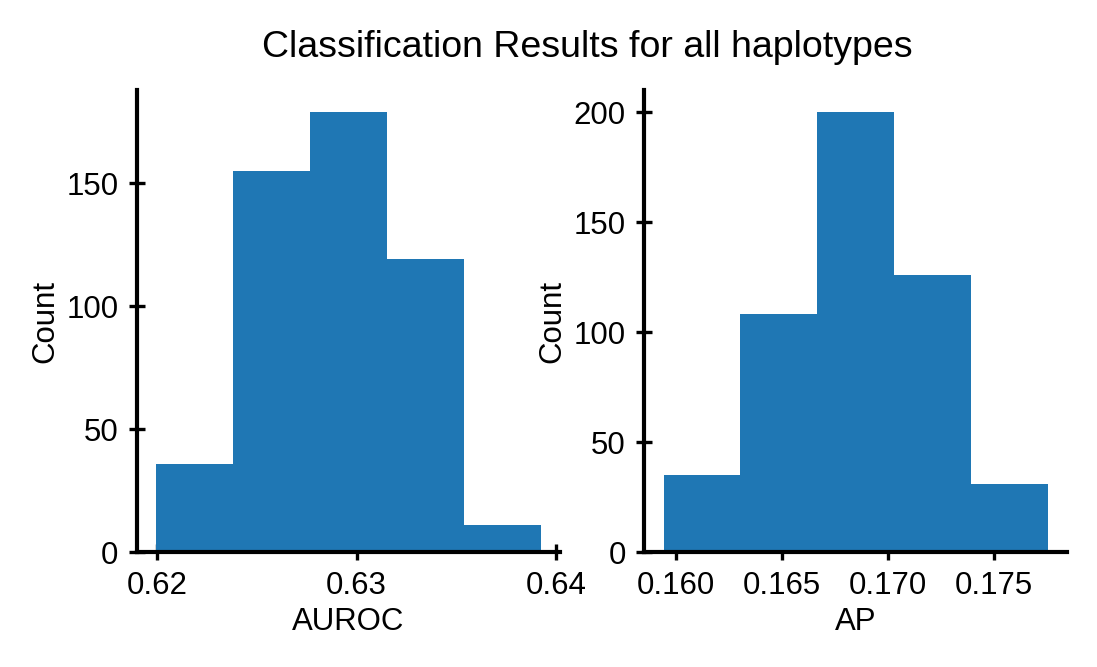

In [26]:
plt.figure(figsize=(4,2))
plt.subplot(1,2,1)
plt.hist(roc_values,5)
plt.ylabel('Count')
plt.xlabel('AUROC')
plt.subplot(1,2,2)
plt.hist(ap_values,5)
plt.ylabel('Count')
plt.xlabel('AP')
plt.suptitle('Classification Results for all haplotypes')
plt.savefig('plots/roc_ap_all_haplotypes.png')

In [2]:
models = ['independent', 'ncov', 'nskew', 'nskewfcov']
for model in models:
    humanviruses_model = load_matrix(f'../maxent/data/mcmc_thermo/Humanviruses_{model}_1e7_60_matrix.csv.gz')
    kmers = matrix_to_kmers(humanviruses_model)
    with open(f"data/netMHC_input/net_mhc_input_Humanviruses_{model}_1e7_60.txt",'w') as f:
        for item in kmers:
            f.write(f"{item}\n")